In [1]:
%load_ext autoreload
%autoreload 2

from notebook_config import setup_notebook
import matplotlib.pyplot as plt
import numpy as np

setup_notebook()

In [2]:
from datasets.stocks_data_wrapper import StocksDataWrapper
from helpers.data_helper import *
from helpers.plots_helper import *

In [3]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(device)

cuda


### Prepare data

In [4]:
DATA_PATH = '../data/'
FILE_SUFFIX='.txt'

quotation = 'IBM'
price_column = 'Close'
project_label='LinearNNRegression'

predict_n = 5

In [5]:
data_wrapper = StocksDataWrapper.read_from(file_path=f"{DATA_PATH}{quotation}{FILE_SUFFIX}", 
                                           compute_features=True, predict_n=predict_n, normalize=True)

data_wrapper.head()

,Date,Open,High,Low,Close,Adjusted,Volume,LowLen,RSI(14),GAP,...,SMA(10),SMA(20),EMA(14),EMA_Diff,SMA(20) - SMA(10),Difference,PercentageDiff,Tendency,NextPrice,Next
0,1962-03-21,0.015428,0.014523,0.015787,0.015429,0.005020,0.003780,0.002525,0.595025,0.000000,...,0.014503,0.013555,0.013679,0.613174,0.394439,0.575048,0.643619,higher,0.014705,higher
1,1962-03-22,0.015334,0.014334,0.015533,0.015051,0.004897,0.003456,0.000000,0.456905,0.001641,...,0.014474,0.013587,0.013637,0.611388,0.394997,0.572212,0.611458,lower,0.014610,lower
2,1962-03-23,0.015113,0.014271,0.015565,0.015177,0.004938,0.002700,0.000000,0.505305,0.000410,...,0.014436,0.013619,0.013618,0.612154,0.395653,0.575703,0.651147,higher,0.014280,lower
3,1962-03-26,0.015207,0.014334,0.015597,0.015162,0.004933,0.001944,0.001263,0.499957,0.000000,...,0.014399,0.013656,0.013600,0.612167,0.396346,0.574721,0.639898,lower,0.013823,lower
4,1962-03-27,0.015113,0.014114,0.014963,0.014516,0.004723,0.005076,0.000842,0.332912,0.001026,...,0.014300,0.013658,0.013496,0.609286,0.397285,0.570357,0.590036,lower,0.013005,lower


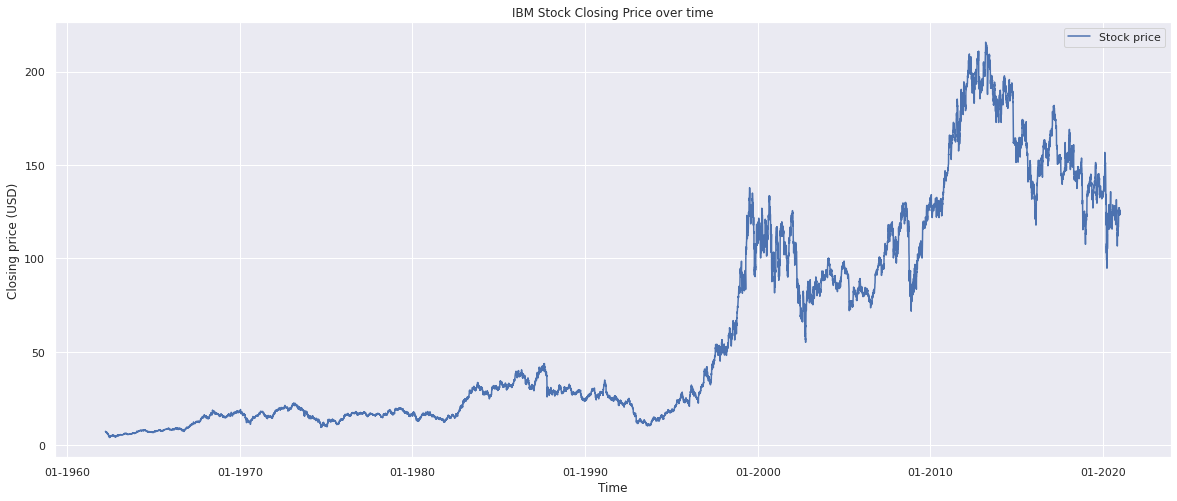

In [6]:
prices = data_wrapper.get_unscaled_data()['Close']
plot_prices(price_series=prices, date_series=data_wrapper['Date'], quotation_name=quotation)
plt.show()

In [ ]:
ax = plot_normalized_histogram(data_wrapper.get_unscaled_data()['Difference'])

In [8]:
from torch.utils.data import Dataset
from datasets.torch_datasets import StocksDataset


y_column = 'NextPrice'
data_columns = ['Close', 'Volume', 'MACD_diff', 'RSI(14)', 'PercentageDiff', 'LowLen', 'RSI_diff']

X_train, X_test, y_train, y_test = data_wrapper.get_datasets(n_splits=1, val_size=0.3, 
                                                             y_column='NextPrice', 
                                                             features_list=data_columns)

In [9]:
from torch.utils.data import DataLoader
train_dataset = StocksDataset(X_train,y_train)
test_dataset = StocksDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)


print(f"Train size : {len(train_dataset)}, test_size : {len(test_dataset)}")

Train size : 10355, test_size : 4438


### Model

In [10]:
from models.pytorch_linear_model import LinearModel
from trainers.pytorch_regression_trainer import PytorchRegressionTrainer

import torch.nn as nn

config = dict(
    lr=1e-5,
    loss=nn.MSELoss,
    n_epochs=5,
    optimizer=torch.optim.Adam,
)
model = LinearModel(config, input_dim=X_train.shape[1], output_dim=1, device=device)
print(model)


trainer = PytorchRegressionTrainer(model, device=device, use_wandb=True, project_label=project_label)
trainer.train(dataloader=train_dataloader)

LinearModel(
  (model): Sequential(
    (0): Linear(in_features=7, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=16, out_features=32, bias=True)
    (4): LeakyReLU(negative_slope=0.1)
    (5): Linear(in_features=32, out_features=32, bias=True)
    (6): LeakyReLU(negative_slope=0.1)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): LeakyReLU(negative_slope=0.1)
    (10): Linear(in_features=16, out_features=1, bias=True)
  )
  (loss_fn): MSELoss()
)
Wandb run page : https://wandb.ai/ludovic_herbelin_unine/LinearNNRegression/runs/3i7hr71o
tensor([[-0.0589],
        [-0.0843],
        [-0.0914],
        [-0.0557],
        [-0.0336],
        [ 0.0022],
        [-0.0049],
        [-0.0471],
        [-0.1064],
        [ 0.0187],
        [-0.1190],
        [-0.0101],
        [ 0.0185],
        [ 0.003

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.0098, 0.0103, 0.0099, 0.0099, 0.0100, 0.0103, 0.0107, 0.0108, 0.0116,
        0.0117, 0.0119, 0.0118, 0.0113, 0.0111, 0.0113, 0.0118, 0.0120, 0.0117,
        0.0112, 0.0118, 0.0115, 0.0112, 0.0110, 0.0111, 0.0112, 0.0114, 0.0115,
        0.0116, 0.0114, 0.0113, 0.0110, 0.0105], device='cuda:0')
tensor([[-0.0273],
        [ 0.0073],
        [-0.0101],
        [-0.0072],
        [-0.0671],
        [ 0.0794],
        [-0.0540],
        [ 0.0091],
        [-0.0256],
        [-0.0289],
        [ 0.0258],
        [ 0.0789],
        [ 0.1076],
        [-0.0113],
        [ 0.0129],
        [-0.0210],
        [-0.0576],
        [-0.0266],
        [-0.0034],
        [-0.0981],
        [-0.0579],
        [-0.0830],
        [-0.0034],
        [-0.0177],
        [-0.0200],
        [-0.0095],
        [ 0.0043],
        [-0.0090],
        [-0.0338],
        [ 0.0460],
        [ 0.0299],
        [ 0.0070]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0105, 0.0100, 0.0100, 0.0104, 0.0

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.0181, 0.0178, 0.0181, 0.0180, 0.0176, 0.0168, 0.0164, 0.0165, 0.0163,
        0.0168, 0.0167, 0.0172, 0.0171, 0.0170, 0.0168, 0.0167, 0.0166, 0.0159,
        0.0156, 0.0162, 0.0168, 0.0170, 0.0173, 0.0170, 0.0168, 0.0175, 0.0177,
        0.0175, 0.0174, 0.0177, 0.0179, 0.0181], device='cuda:0')
tensor([[ 0.0009],
        [-0.0387],
        [-0.0254],
        [-0.0041],
        [-0.0248],
        [-0.0024],
        [-0.0580],
        [-0.0504],
        [-0.0612],
        [ 0.0950],
        [ 0.0275],
        [-0.0359],
        [-0.0212],
        [ 0.0333],
        [-0.0111],
        [-0.0129],
        [ 0.0134],
        [-0.0471],
        [-0.0115],
        [ 0.0152],
        [ 0.0049],
        [-0.0405],
        [-0.0195],
        [ 0.0140],
        [-0.0423],
        [-0.0093],
        [-0.0283],
        [-0.0193],
        [-0.0581],
        [-0.0802],
        [-0.0757],
        [ 0.0035]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0181, 0.0174, 0.0172, 0.0170, 0.0

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size


tensor([0.0260, 0.0252, 0.0257, 0.0259, 0.0258, 0.0248, 0.0246, 0.0244, 0.0248,
        0.0247, 0.0244, 0.0241, 0.0239, 0.0241, 0.0243, 0.0246, 0.0243, 0.0238,
        0.0242, 0.0254, 0.0263, 0.0267, 0.0273, 0.0270, 0.0275, 0.0261, 0.0265,
        0.0269, 0.0268, 0.0268, 0.0277, 0.0279], device='cuda:0')
tensor([[-0.0331],
        [-0.0408],
        [-0.0817],
        [ 0.0402],
        [-0.0002],
        [ 0.0131],
        [-0.0047],
        [-0.0211],
        [ 0.0002],
        [-0.0146],
        [ 0.0276],
        [ 0.0374],
        [ 0.0127],
        [ 0.0029],
        [ 0.0140],
        [ 0.0019],
        [-0.0047],
        [-0.0153],
        [ 0.0775],
        [ 0.1188],
        [ 0.0157],
        [ 0.0255],
        [-0.0082],
        [ 0.0087],
        [ 0.0019],
        [-0.0009],
        [-0.0321],
        [ 0.0355],
        [-0.0004],
        [-0.0008],
        [ 0.0213],
        [ 0.0256]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0275, 0.0276, 0.0281, 0.0285, 0.

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.0621, 0.0619, 0.0606, 0.0610, 0.0606, 0.0606, 0.0598, 0.0602, 0.0608,
        0.0610, 0.0611, 0.0607, 0.0603, 0.0603, 0.0604, 0.0601, 0.0603, 0.0600,
        0.0589, 0.0603, 0.0603, 0.0600, 0.0592, 0.0598, 0.0580, 0.0574, 0.0589,
        0.0587, 0.0588, 0.0585, 0.0575, 0.0562], device='cuda:0')
tensor([[ 0.0020],
        [ 0.0299],
        [ 0.0040],
        [-0.0265],
        [ 0.0548],
        [ 0.0530],
        [ 0.0439],
        [-0.0377],
        [-0.0050],
        [-0.0038],
        [-0.0345],
        [ 0.0209],
        [-0.0562],
        [ 0.0390],
        [ 0.0179],
        [ 0.0153],
        [-0.0054],
        [-0.0392],
        [ 0.0150],
        [ 0.0250],
        [ 0.0248],
        [ 0.0251],
        [ 0.0346],
        [-0.0337],
        [-0.0240],
        [-0.0206],
        [-0.0260],
        [ 0.0461],
        [-0.0387],
        [-0.0190],
        [ 0.0301],
        [ 0.0391]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0551, 0.0561, 0.0580, 0.0580, 0.0

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor([[-0.0670],
        [ 0.0068],
        [ 0.0342],
        [-0.0227],
        [-0.0469],
        [ 0.0081],
        [-0.0268],
        [-0.0103],
        [-0.0586],
        [-0.0507],
        [-0.0032],
        [ 0.0132],
        [-0.0189],
        [ 0.0175],
        [-0.0149],
        [-0.0019],
        [-0.0287],
        [-0.0074],
        [-0.0078],
        [-0.0203],
        [ 0.0099],
        [-0.0542],
        [-0.0524],
        [-0.0093],
        [ 0.0064],
        [-0.0429],
        [-0.0448],
        [-0.0164],
        [-0.0155],
        [-0.0242],
        [ 0.0334],
        [-0.0474]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0582, 0.0565, 0.0555, 0.0553, 0.0562, 0.0577, 0.0568, 0.0558, 0.0565,
        0.0562, 0.0561, 0.0548, 0.0551, 0.0548, 0.0544, 0.0522, 0.0524, 0.0530,
        0.0539, 0.0529, 0.0516, 0.0536, 0.0536, 0.0546, 0.0533, 0.0516, 0.0523,
        0.0523, 0.0517, 0.0515, 0.0515, 0.0515], device='cuda:0')
tensor([[-0.0351],
        [-0.0917],
     

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.0482, 0.0474, 0.0457, 0.0441, 0.0447, 0.0445, 0.0418, 0.0399, 0.0387,
        0.0393, 0.0376, 0.0379, 0.0419, 0.0438, 0.0464, 0.0485, 0.0476, 0.0476,
        0.0448, 0.0445, 0.0436, 0.0441, 0.0434, 0.0420, 0.0419, 0.0419, 0.0447,
        0.0435, 0.0450, 0.0446, 0.0441, 0.0415], device='cuda:0')
tensor([[-0.0269],
        [ 0.0195],
        [ 0.0386],
        [ 0.0111],
        [-0.1119],
        [-0.0475],
        [-0.0739],
        [ 0.0049],
        [-0.0644],
        [-0.0445],
        [-0.0105],
        [-0.0264],
        [ 0.0114],
        [-0.0730],
        [ 0.0016],
        [-0.0171],
        [-0.0251],
        [-0.0257],
        [ 0.0159],
        [-0.0170],
        [-0.0127],
        [ 0.1011],
        [ 0.0240],
        [ 0.0470],
        [ 0.0172],
        [ 0.0605],
        [-0.0021],
        [-0.0871],
        [ 0.0010],
        [-0.0192],
        [ 0.0038],
        [-0.0348]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0410, 0.0417, 0.0415, 0.0415, 0.0

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.0502, 0.0502, 0.0520, 0.0518, 0.0503, 0.0500, 0.0496, 0.0493, 0.0496,
        0.0513, 0.0521, 0.0529, 0.0539, 0.0538, 0.0565, 0.0547, 0.0556, 0.0548,
        0.0557, 0.0574, 0.0573, 0.0563, 0.0580, 0.0608, 0.0608, 0.0614, 0.0624,
        0.0613, 0.0601, 0.0595, 0.0608, 0.0603], device='cuda:0')
tensor([[ 0.0136],
        [ 0.0277],
        [ 0.0240],
        [-0.0421],
        [-0.0517],
        [-0.1077],
        [ 0.0122],
        [ 0.0149],
        [-0.0350],
        [ 0.0100],
        [-0.0303],
        [-0.0549],
        [-0.0044],
        [-0.0335],
        [-0.0518],
        [ 0.0223],
        [ 0.0039],
        [ 0.0256],
        [-0.0096],
        [-0.0064],
        [ 0.1240],
        [ 0.1305],
        [ 0.0306],
        [ 0.0223],
        [-0.0581],
        [-0.0552],
        [-0.0463],
        [-0.0028],
        [ 0.0044],
        [-0.0327],
        [ 0.0095],
        [ 0.0034]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0598, 0.0602, 0.0594, 0.0610, 0.0

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.0753, 0.0771, 0.0762, 0.0749, 0.0736, 0.0722, 0.0722, 0.0743, 0.0737,
        0.0758, 0.0764, 0.0761, 0.0779, 0.0780, 0.0755, 0.0747, 0.0734, 0.0746,
        0.0756, 0.0739, 0.0742, 0.0719, 0.0731, 0.0732, 0.0751, 0.0743, 0.0708,
        0.0688, 0.0693, 0.0694, 0.0709, 0.0734], device='cuda:0')
tensor([[-0.0575],
        [ 0.0156],
        [-0.0868],
        [-0.0394],
        [ 0.0248],
        [ 0.1205],
        [-0.0010],
        [-0.0201],
        [ 0.1015],
        [ 0.0075],
        [-0.0270],
        [-0.0033],
        [-0.0122],
        [-0.0271],
        [ 0.0079],
        [-0.0323],
        [ 0.0272],
        [ 0.0365],
        [ 0.0728],
        [-0.0257],
        [ 0.0058],
        [-0.0051],
        [-0.0603],
        [-0.0030],
        [-0.0418],
        [-0.0416],
        [-0.0751],
        [-0.0452],
        [-0.0427],
        [ 0.0406],
        [-0.0072],
        [-0.0380]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0752, 0.0733, 0.0722, 0.0749, 0.0

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size


tensor([0.0331, 0.0311, 0.0304, 0.0308, 0.0298, 0.0293, 0.0305, 0.0315, 0.0314,
        0.0308, 0.0301, 0.0295, 0.0314, 0.0309, 0.0306, 0.0308, 0.0297, 0.0301,
        0.0294, 0.0286, 0.0292, 0.0303, 0.0306, 0.0302, 0.0299, 0.0297, 0.0289,
        0.0305, 0.0313, 0.0307, 0.0304, 0.0290], device='cuda:0')
tensor([[-0.0432],
        [-0.0237],
        [-0.0151],
        [ 0.0261],
        [-0.0234],
        [ 0.0431],
        [ 0.0925],
        [ 0.0161],
        [ 0.0638],
        [ 0.0143],
        [-0.0451],
        [-0.0396],
        [-0.0638],
        [ 0.0299],
        [ 0.0743],
        [ 0.0622],
        [ 0.0484],
        [ 0.0148],
        [-0.0076],
        [ 0.0626],
        [ 0.0119],
        [ 0.0140],
        [ 0.0126],
        [-0.0257],
        [-0.0170],
        [ 0.0049],
        [ 0.0059],
        [-0.0087],
        [-0.0122],
        [-0.0444],
        [ 0.0018],
        [-0.0608]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0282, 0.0274, 0.0280, 0.0279, 0.

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.0554, 0.0555, 0.0562, 0.0568, 0.0576, 0.0572, 0.0581, 0.0601, 0.0593,
        0.0606, 0.0601, 0.0610, 0.0620, 0.0618, 0.0615, 0.0621, 0.0624, 0.0618,
        0.0622, 0.0619, 0.0628, 0.0624, 0.0628, 0.0633, 0.0627, 0.0624, 0.0623,
        0.0617, 0.0610, 0.0606, 0.0607, 0.0612], device='cuda:0')
tensor([[-0.0314],
        [-0.0682],
        [ 0.0431],
        [ 0.0338],
        [ 0.0097],
        [ 0.0023],
        [ 0.0009],
        [-0.0162],
        [ 0.0032],
        [ 0.0206],
        [-0.0319],
        [-0.0031],
        [ 0.0052],
        [ 0.0505],
        [-0.0218],
        [ 0.0309],
        [-0.0140],
        [ 0.0378],
        [-0.0164],
        [ 0.0256],
        [ 0.0113],
        [-0.0173],
        [ 0.0350],
        [ 0.0710],
        [-0.0306],
        [-0.0161],
        [ 0.0753],
        [-0.0952],
        [-0.0765],
        [-0.0178],
        [-0.0408],
        [-0.0344]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0613, 0.0621, 0.0611, 0.0613, 0.0

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([[-0.0525],
        [ 0.0160],
        [-0.0110],
        [ 0.0080],
        [ 0.0118],
        [-0.0317],
        [ 0.0082],
        [ 0.0074],
        [ 0.0186],
        [-0.0216],
        [-0.0054],
        [-0.0109],
        [-0.0323],
        [-0.0290],
        [ 0.0057],
        [ 0.0030],
        [-0.0142],
        [ 0.0258],
        [-0.0090],
        [-0.0605],
        [-0.0370],
        [ 0.0888],
        [-0.0498],
        [-0.0949],
        [-0.0685],
        [ 0.0780],
        [-0.0519],
        [ 0.0174],
        [ 0.1182],
        [ 0.0402],
        [ 0.0016],
        [-0.0098]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0556, 0.0570, 0.0571, 0.0567, 0.0567, 0.0575, 0.0574, 0.0576, 0.0581,
        0.0593, 0.0596, 0.0587, 0.0590, 0.0587, 0.0580, 0.0579, 0.0574, 0.0579,
        0.0572, 0.0574, 0.0573, 0.0578, 0.0605, 0.0616, 0.0619, 0.0613, 0.0613,
        0.0614, 0.0616, 0.0609, 0.0597, 0.0595], device='cuda:0')
tensor([[ 0.1130],
        [ 0.0979],
     

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([[-0.0010],
        [ 0.0438],
        [ 0.0219],
        [-0.0003],
        [-0.0277],
        [-0.0066],
        [ 0.0302],
        [-0.0201],
        [ 0.0456],
        [ 0.0209],
        [ 0.0617],
        [ 0.0410],
        [ 0.0066],
        [ 0.0150],
        [-0.0458],
        [ 0.0035],
        [-0.0598],
        [-0.0234],
        [-0.0531],
        [-0.0448],
        [ 0.0006],
        [ 0.0056],
        [ 0.0675],
        [-0.0257],
        [ 0.0178],
        [-0.0142],
        [-0.0109],
        [ 0.0394],
        [ 0.0190],
        [ 0.0380],
        [ 0.0119],
        [-0.0214]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0642, 0.0647, 0.0645, 0.0678, 0.0721, 0.0700, 0.0705, 0.0688, 0.0703,
        0.0712, 0.0708, 0.0711, 0.0706, 0.0711, 0.0709, 0.0727, 0.0731, 0.0739,
        0.0721, 0.0723, 0.0725, 0.0712, 0.0727, 0.0726, 0.0718, 0.0728, 0.0731,
        0.0726, 0.0728, 0.0719, 0.0725, 0.0717], device='cuda:0')
tensor([[-0.0200],
        [-0.0213],
     

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.0424, 0.0436, 0.0433, 0.0427, 0.0433, 0.0438, 0.0430, 0.0432, 0.0442,
        0.0454, 0.0460, 0.0473, 0.0449, 0.0461, 0.0469, 0.0473, 0.0494, 0.0480,
        0.0482, 0.0477, 0.0486, 0.0492, 0.0492, 0.0502, 0.0520, 0.0502, 0.0511,
        0.0491, 0.0491, 0.0502, 0.0508, 0.0513], device='cuda:0')
tensor([[ 0.0111],
        [ 0.0276],
        [ 0.0001],
        [-0.0196],
        [-0.0024],
        [-0.0280],
        [ 0.0175],
        [ 0.0147],
        [ 0.0016],
        [ 0.0041],
        [-0.0124],
        [ 0.0566],
        [ 0.0203],
        [ 0.0282],
        [-0.0229],
        [-0.0123],
        [ 0.0834],
        [ 0.0528],
        [ 0.0105],
        [ 0.0140],
        [-0.0176],
        [ 0.0226],
        [ 0.0069],
        [-0.0012],
        [-0.0554],
        [ 0.0527],
        [ 0.0070],
        [ 0.0172],
        [ 0.0054],
        [ 0.0259],
        [-0.0212],
        [ 0.0283]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0507, 0.0513, 0.0501, 0.0510, 0.0

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.0410, 0.0402, 0.0402, 0.0405, 0.0404, 0.0424, 0.0429, 0.0451, 0.0451,
        0.0446, 0.0433, 0.0445, 0.0452, 0.0439, 0.0436, 0.0443, 0.0452, 0.0449,
        0.0438, 0.0440, 0.0446, 0.0466, 0.0477, 0.0473, 0.0479, 0.0470, 0.0480,
        0.0474, 0.0469, 0.0483, 0.0479, 0.0495], device='cuda:0')
tensor([[-0.0485],
        [-0.0721],
        [-0.0302],
        [-0.0401],
        [ 0.0072],
        [ 0.0313],
        [-0.0452],
        [-0.0465],
        [ 0.0038],
        [-0.0359],
        [-0.0079],
        [ 0.0144],
        [ 0.0155],
        [-0.0020],
        [ 0.0057],
        [-0.0398],
        [ 0.0452],
        [ 0.0368],
        [-0.0207],
        [-0.0591],
        [-0.0186],
        [ 0.0195],
        [-0.0565],
        [ 0.0130],
        [-0.0389],
        [ 0.0169],
        [ 0.0062],
        [-0.0461],
        [-0.0433],
        [-0.0485],
        [-0.0914],
        [ 0.0292]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0480, 0.0477, 0.0477, 0.0477, 0.0

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size


tensor([0.0973, 0.0998, 0.0993, 0.0976, 0.1009, 0.1013, 0.1010, 0.1015, 0.1024,
        0.0998, 0.1015, 0.0991, 0.0997, 0.0994, 0.0998, 0.0975, 0.0975, 0.0987,
        0.0997, 0.0990, 0.1013, 0.1015, 0.1013, 0.1016, 0.1022, 0.1038, 0.1009,
        0.1016, 0.1012, 0.1019, 0.1026, 0.1034], device='cuda:0')
tensor([[-0.0438],
        [ 0.0283],
        [ 0.0216],
        [-0.0301],
        [-0.0222],
        [-0.0003],
        [ 0.0266],
        [ 0.0249],
        [ 0.0082],
        [-0.0014],
        [ 0.0537],
        [ 0.0075],
        [-0.0690],
        [ 0.0099],
        [ 0.0091],
        [-0.0391],
        [ 0.0242],
        [ 0.0136],
        [-0.0154],
        [-0.0326],
        [ 0.0519],
        [ 0.0206],
        [-0.0501],
        [-0.0064],
        [ 0.0141],
        [-0.0253],
        [ 0.0232],
        [ 0.0539],
        [ 0.0217],
        [ 0.0073],
        [-0.0314],
        [ 0.0261]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.1066, 0.1071, 0.1091, 0.1100, 0.

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.1236, 0.1215, 0.1243, 0.1193, 0.1211, 0.1199, 0.1208, 0.1196, 0.1215,
        0.1212, 0.1251, 0.1271, 0.1249, 0.1235, 0.1218, 0.1235, 0.1239, 0.1245,
        0.1267, 0.1258, 0.1267, 0.1279, 0.1274, 0.1261, 0.1248, 0.1245, 0.1270,
        0.1274, 0.1266, 0.1263, 0.1251, 0.1251], device='cuda:0')
tensor([[-0.0213],
        [-0.0063],
        [-0.0274],
        [-0.0059],
        [-0.0406],
        [-0.0484],
        [-0.0055],
        [-0.0438],
        [-0.0361],
        [-0.0109],
        [ 0.0298],
        [ 0.0043],
        [ 0.0136],
        [-0.0626],
        [ 0.0176],
        [-0.0538],
        [-0.0235],
        [-0.0221],
        [ 0.0195],
        [-0.0166],
        [ 0.0339],
        [-0.0500],
        [ 0.0549],
        [ 0.0089],
        [-0.0635],
        [ 0.0052],
        [ 0.0005],
        [-0.0340],
        [ 0.0279],
        [-0.0071],
        [ 0.0038],
        [-0.0290]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.1239, 0.1212, 0.1230, 0.1236, 0.1

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([[-0.0712],
        [-0.1174],
        [ 0.0475],
        [-0.0190],
        [-0.0027],
        [ 0.0251],
        [ 0.0400],
        [ 0.0256],
        [ 0.0122],
        [-0.0245],
        [ 0.0442],
        [-0.0073],
        [ 0.0555],
        [-0.0352],
        [-0.0640],
        [ 0.0258],
        [-0.0565],
        [-0.0447],
        [-0.0213],
        [-0.0286],
        [ 0.0816],
        [ 0.0242],
        [ 0.0647],
        [ 0.0315],
        [ 0.0621],
        [ 0.0419],
        [ 0.0135],
        [ 0.0014],
        [-0.0131],
        [-0.0057],
        [ 0.0078],
        [ 0.0377]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.1339, 0.1325, 0.1339, 0.1311, 0.1314, 0.1295, 0.1233, 0.1208, 0.1238,
        0.1226, 0.1223, 0.1217, 0.1209, 0.1217, 0.1235, 0.1248, 0.1261, 0.1271,
        0.1269, 0.1282, 0.1276, 0.1269, 0.1277, 0.1266, 0.1239, 0.1260, 0.1269,
        0.1274, 0.1289, 0.1325, 0.1335, 0.1328], device='cuda:0')
tensor([[ 5.4762e-07],
        [-7.5859e-03

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([[ 0.1375],
        [ 0.0034],
        [-0.0140],
        [-0.0738],
        [-0.0690],
        [ 0.0073],
        [ 0.0226],
        [-0.0475],
        [-0.0139],
        [-0.0072],
        [-0.0156],
        [-0.0069],
        [ 0.0356],
        [ 0.0210],
        [-0.0427],
        [ 0.0215],
        [-0.0217],
        [ 0.0228],
        [-0.0326],
        [-0.0007],
        [ 0.0771],
        [ 0.0406],
        [ 0.0264],
        [ 0.0082],
        [ 0.0143],
        [ 0.0132],
        [ 0.0960],
        [ 0.0277],
        [-0.0541],
        [-0.0022],
        [ 0.0810],
        [-0.0508]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.1559, 0.1568, 0.1555, 0.1574, 0.1561, 0.1542, 0.1536, 0.1519, 0.1549,
        0.1521, 0.1537, 0.1549, 0.1540, 0.1543, 0.1537, 0.1562, 0.1573, 0.1567,
        0.1522, 0.1515, 0.1511, 0.1528, 0.1497, 0.1452, 0.1410, 0.1379, 0.1366,
        0.1363, 0.1364, 0.1385, 0.1379, 0.1379], device='cuda:0')
tensor([[-0.0391],
        [-0.0007],
     

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.1227, 0.1254, 0.1277, 0.1246, 0.1232, 0.1269, 0.1218, 0.1202, 0.1198,
        0.1215, 0.1251, 0.1243, 0.1224, 0.1198, 0.1205, 0.1173, 0.1198, 0.1195,
        0.1207, 0.1196, 0.1164, 0.1115, 0.1121, 0.1112, 0.1065, 0.1080, 0.1100,
        0.1124, 0.1153, 0.1118, 0.1108, 0.1167], device='cuda:0')
tensor([[-0.0420],
        [-0.0272],
        [ 0.0491],
        [-0.0045],
        [ 0.0258],
        [ 0.0703],
        [ 0.1000],
        [ 0.0359],
        [ 0.0784],
        [-0.0229],
        [-0.0036],
        [-0.0434],
        [-0.0136],
        [-0.0444],
        [-0.0735],
        [-0.0734],
        [-0.0803],
        [-0.0281],
        [ 0.0951],
        [-0.0413],
        [ 0.0387],
        [-0.0213],
        [ 0.0736],
        [ 0.0706],
        [ 0.0244],
        [-0.0661],
        [-0.0093],
        [ 0.0109],
        [ 0.0021],
        [-0.0250],
        [-0.0455],
        [ 0.0340]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.1177, 0.1211, 0.1171, 0.1192, 0.1

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.1100, 0.1103, 0.1102, 0.1096, 0.1115, 0.1139, 0.1122, 0.1124, 0.1130,
        0.1119, 0.1105, 0.1100, 0.1103, 0.1102, 0.1100, 0.1086, 0.1102, 0.1106,
        0.1108, 0.1094, 0.1102, 0.1100, 0.1097, 0.1087, 0.1093, 0.1118, 0.1111,
        0.1099, 0.1100, 0.1111, 0.1100, 0.1103], device='cuda:0')
tensor([[-0.0162],
        [-0.0273],
        [-0.0224],
        [-0.0329],
        [ 0.0393],
        [ 0.0336],
        [ 0.0317],
        [-0.0091],
        [ 0.1317],
        [ 0.1434],
        [ 0.0176],
        [ 0.0593],
        [-0.0517],
        [-0.0951],
        [ 0.0015],
        [ 0.0162],
        [-0.0052],
        [ 0.0128],
        [-0.0113],
        [ 0.0417],
        [ 0.0193],
        [-0.0125],
        [-0.0152],
        [ 0.0042],
        [ 0.0501],
        [-0.0082],
        [-0.0403],
        [ 0.1011],
        [ 0.0367],
        [-0.0061],
        [-0.0472],
        [-0.0183]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.1096, 0.1117, 0.1130, 0.1158, 0.1

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([[ 0.0080],
        [ 0.0097],
        [-0.0339],
        [-0.0506],
        [-0.0447],
        [-0.0344],
        [-0.0677],
        [ 0.0757],
        [ 0.0501],
        [ 0.0537],
        [ 0.0699],
        [ 0.0058],
        [-0.0828],
        [-0.0096],
        [-0.0572],
        [ 0.0238],
        [-0.0433],
        [-0.0392],
        [ 0.0401],
        [ 0.0750],
        [ 0.0064],
        [ 0.0568],
        [-0.0175],
        [ 0.0401],
        [-0.0240],
        [ 0.0594],
        [ 0.0365],
        [ 0.1060],
        [ 0.0241],
        [ 0.0593],
        [ 0.0105],
        [-0.0187]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.1146, 0.1142, 0.1131, 0.1136, 0.1131, 0.1109, 0.1094, 0.1069, 0.1087,
        0.1084, 0.1068, 0.1077, 0.1096, 0.1174, 0.1196, 0.1220, 0.1201, 0.1215,
        0.1236, 0.1255, 0.1274, 0.1277, 0.1307, 0.1304, 0.1305, 0.1311, 0.1325,
        0.1341, 0.1325, 0.1336, 0.1370, 0.1375], device='cuda:0')
tensor([[-0.0215],
        [ 0.0741],
     

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.0821, 0.0823, 0.0812, 0.0836, 0.0827, 0.0839, 0.0838, 0.0830, 0.0842,
        0.0840, 0.0830, 0.0823, 0.0824, 0.0833, 0.0840, 0.0846, 0.0851, 0.0817,
        0.0789, 0.0796, 0.0793, 0.0804, 0.0790, 0.0795, 0.0781, 0.0779, 0.0784,
        0.0764, 0.0761, 0.0753, 0.0734, 0.0739], device='cuda:0')
tensor([[-3.2356e-02],
        [-1.3150e-02],
        [ 2.1104e-02],
        [ 4.8975e-02],
        [ 6.0934e-02],
        [-3.4927e-02],
        [ 2.9698e-02],
        [-6.1457e-02],
        [-6.7196e-03],
        [ 1.7756e-02],
        [-1.2206e-02],
        [-1.6426e-04],
        [ 1.6868e-01],
        [ 1.4058e-01],
        [ 7.4076e-02],
        [-7.6286e-02],
        [ 2.8017e-02],
        [-1.0282e-02],
        [-3.3190e-02],
        [-3.0945e-02],
        [ 1.9604e-02],
        [-2.6537e-03],
        [ 1.0634e-02],
        [-1.5255e-02],
        [ 3.7072e-02],
        [ 2.4996e-02],
        [-6.1016e-03],
        [ 3.7709e-02],
        [ 6.2069e-03],
        [-1.3176e-02],
    

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.0432, 0.0432, 0.0440, 0.0433, 0.0429, 0.0429, 0.0424, 0.0454, 0.0461,
        0.0469, 0.0467, 0.0486, 0.0485, 0.0495, 0.0491, 0.0482, 0.0500, 0.0495,
        0.0483, 0.0473, 0.0445, 0.0440, 0.0429, 0.0439, 0.0452, 0.0433, 0.0438,
        0.0435, 0.0435, 0.0427, 0.0433, 0.0432], device='cuda:0')
tensor([[-0.0502],
        [-0.0386],
        [-0.0643],
        [ 0.0246],
        [ 0.0330],
        [ 0.0514],
        [-0.0022],
        [ 0.0393],
        [ 0.0006],
        [ 0.0355],
        [-0.0328],
        [ 0.2196],
        [ 0.2104],
        [ 0.0834],
        [-0.0223],
        [ 0.0227],
        [-0.0175],
        [ 0.0226],
        [-0.0714],
        [-0.0406],
        [ 0.0430],
        [ 0.0090],
        [-0.0016],
        [-0.0389],
        [ 0.0422],
        [ 0.0025],
        [-0.0387],
        [-0.0678],
        [ 0.1103],
        [ 0.0579],
        [ 0.0848],
        [ 0.0381]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0426, 0.0443, 0.0433, 0.0438, 0.0

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.1001, 0.0997, 0.0981, 0.0975, 0.0945, 0.0959, 0.0925, 0.0910, 0.0897,
        0.0919, 0.0950, 0.0938, 0.0922, 0.0916, 0.0902, 0.0904, 0.0922, 0.0916,
        0.0923, 0.0911, 0.0928, 0.0914, 0.0923, 0.0919, 0.0894, 0.0879, 0.0900,
        0.0905, 0.0900, 0.0917, 0.0951, 0.0945], device='cuda:0')
tensor([[ 0.0325],
        [ 0.0486],
        [-0.0437],
        [ 0.1660],
        [ 0.2158],
        [ 0.0464],
        [-0.0308],
        [ 0.1108],
        [ 0.0273],
        [ 0.0171],
        [ 0.0401],
        [-0.0406],
        [-0.0331],
        [-0.0034],
        [-0.0413],
        [ 0.0368],
        [ 0.0523],
        [-0.0208],
        [ 0.0728],
        [ 0.0184],
        [-0.0326],
        [-0.0337],
        [ 0.0328],
        [ 0.0923],
        [-0.0552],
        [ 0.0440],
        [ 0.0344],
        [ 0.0804],
        [-0.0374],
        [-0.0656],
        [-0.0945],
        [-0.0020]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0967, 0.0933, 0.0976, 0.0964, 0.0

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([[ 0.0663],
        [ 0.0867],
        [ 0.0484],
        [-0.0313],
        [ 0.0497],
        [-0.0131],
        [-0.0355],
        [ 0.0770],
        [-0.0125],
        [ 0.0301],
        [ 0.0282],
        [ 0.0153],
        [-0.0132],
        [ 0.0050],
        [-0.0353],
        [-0.0102],
        [-0.0862],
        [ 0.0066],
        [-0.0690],
        [ 0.0319],
        [ 0.0745],
        [-0.0177],
        [ 0.0190],
        [ 0.0599],
        [ 0.0437],
        [ 0.0124],
        [-0.0248],
        [ 0.0115],
        [-0.0094],
        [ 0.0111],
        [ 0.0700],
        [ 0.0298]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.1697, 0.1670, 0.1651, 0.1598, 0.1612, 0.1562, 0.1601, 0.1680, 0.1674,
        0.1633, 0.1629, 0.1646, 0.1646, 0.1639, 0.1621, 0.1596, 0.1617, 0.1686,
        0.1711, 0.1736, 0.1695, 0.1719, 0.1732, 0.1742, 0.1779, 0.1751, 0.1762,
        0.1759, 0.1779, 0.1791, 0.1673, 0.1599], device='cuda:0')
tensor([[ 0.0028],
        [-0.0160],
     

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size


tensor([0.2154, 0.2128, 0.2070, 0.2133, 0.2207, 0.2215, 0.2234, 0.2194, 0.2157,
        0.2114, 0.2145, 0.2089, 0.2148, 0.2204, 0.2252, 0.2219, 0.2241, 0.2281,
        0.2300, 0.2243, 0.2343, 0.2399, 0.2393, 0.2466, 0.2423, 0.2414, 0.2387,
        0.2458, 0.2473, 0.2414, 0.2322, 0.2207], device='cuda:0')
tensor([[ 0.0504],
        [-0.0474],
        [-0.0347],
        [-0.0012],
        [-0.0547],
        [-0.0266],
        [ 0.0230],
        [ 0.0121],
        [-0.0415],
        [-0.0026],
        [ 0.0892],
        [ 0.0241],
        [-0.0166],
        [-0.0556],
        [-0.0706],
        [ 0.0090],
        [-0.0258],
        [ 0.0099],
        [ 0.0275],
        [ 0.0897],
        [ 0.0096],
        [ 0.0334],
        [-0.0168],
        [-0.0211],
        [-0.0182],
        [-0.0404],
        [ 0.0270],
        [ 0.0002],
        [ 0.0264],
        [ 0.0341],
        [-0.0027],
        [ 0.0092]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.2178, 0.2190, 0.2257, 0.2216, 0.

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.4970, 0.5026, 0.5133, 0.5617, 0.5457, 0.5416, 0.5440, 0.5378, 0.5307,
        0.5248, 0.5091, 0.5031, 0.5387, 0.5286, 0.5286, 0.5097, 0.5180, 0.5142,
        0.5286, 0.5499, 0.5316, 0.5333, 0.5251, 0.5207, 0.5263, 0.5280, 0.5508,
        0.5484, 0.5511, 0.5700, 0.5635, 0.5614], device='cuda:0')
tensor([[-0.0045],
        [ 0.1047],
        [ 0.0292],
        [ 0.0701],
        [-0.0014],
        [ 0.0320],
        [-0.0524],
        [-0.0048],
        [-0.0083],
        [ 0.0453],
        [ 0.1415],
        [ 0.0337],
        [ 0.0217],
        [ 0.0751],
        [ 0.0429],
        [ 0.0888],
        [ 0.0437],
        [-0.0115],
        [ 0.0554],
        [ 0.0636],
        [-0.0059],
        [-0.0342],
        [ 0.0407],
        [ 0.0416],
        [ 0.1243],
        [ 0.1031],
        [ 0.0005],
        [ 0.0295],
        [ 0.0484],
        [-0.0574],
        [-0.0436],
        [ 0.0470]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.5596, 0.5623, 0.5596, 0.5694, 0.5

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.3822, 0.3813, 0.4277, 0.4209, 0.4247, 0.4226, 0.4179, 0.4221, 0.4232,
        0.4238, 0.4188, 0.4374, 0.4923, 0.5062, 0.4935, 0.4959, 0.5023, 0.5038,
        0.5201, 0.5238, 0.5315, 0.5097, 0.5194, 0.5016, 0.5108, 0.5201, 0.5329,
        0.5196, 0.5097, 0.5234, 0.5180, 0.5244], device='cuda:0')
tensor([[-0.1656],
        [ 0.0577],
        [ 0.0080],
        [ 0.0142],
        [-0.0026],
        [ 0.0354],
        [ 0.0297],
        [ 0.0046],
        [ 0.0273],
        [-0.0277],
        [-0.0654],
        [-0.0760],
        [-0.0208],
        [ 0.0091],
        [ 0.0010],
        [ 0.0279],
        [-0.0289],
        [-0.0055],
        [ 0.0082],
        [ 0.0170],
        [ 0.0219],
        [ 0.0071],
        [ 0.0041],
        [ 0.0032],
        [ 0.0245],
        [ 0.0065],
        [-0.0115],
        [ 0.0036],
        [-0.0199],
        [-0.0148],
        [ 0.0045],
        [ 0.0402]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.5323, 0.5239, 0.5074, 0.4885, 0.4

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([[ 0.0875],
        [ 0.0460],
        [-0.0096],
        [-0.0214],
        [ 0.0212],
        [ 0.1421],
        [ 0.0402],
        [ 0.0205],
        [ 0.0675],
        [ 0.1121],
        [ 0.0853],
        [ 0.0212],
        [-0.0257],
        [-0.0222],
        [ 0.0399],
        [ 0.0220],
        [ 0.0365],
        [ 0.0219],
        [ 0.0134],
        [ 0.0311],
        [ 0.0188],
        [ 0.0052],
        [ 0.0521],
        [-0.0087],
        [ 0.0222],
        [-0.0415],
        [-0.0310],
        [-0.0252],
        [-0.0641],
        [ 0.0515],
        [-0.0003],
        [-0.0130]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.2873, 0.3217, 0.3314, 0.3376, 0.3326, 0.3331, 0.3213, 0.3329, 0.3423,
        0.3432, 0.3523, 0.3536, 0.3605, 0.3704, 0.3665, 0.3659, 0.3536, 0.3472,
        0.3458, 0.3546, 0.3555, 0.3620, 0.3586, 0.3547, 0.3509, 0.3662, 0.3817,
        0.3795, 0.3879, 0.3825, 0.3950, 0.3913], device='cuda:0')
tensor([[ 0.0669],
        [ 0.1306],
     

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.0073, 0.0077, 0.0086, 0.0090, 0.0087, 0.0086, 0.0088, 0.0088, 0.0086,
        0.0085, 0.0085, 0.0091, 0.0095, 0.0098, 0.0099, 0.0100, 0.0103, 0.0102,
        0.0099, 0.0100, 0.0102, 0.0100, 0.0096, 0.0097, 0.0103, 0.0104, 0.0106,
        0.0104, 0.0104, 0.0105, 0.0103, 0.0101], device='cuda:0')
tensor([[ 0.0048],
        [ 0.0392],
        [ 0.0140],
        [-0.0073],
        [-0.0484],
        [ 0.0605],
        [ 0.0188],
        [-0.0065],
        [ 0.0132],
        [ 0.0052],
        [ 0.0290],
        [ 0.0074],
        [ 0.0170],
        [ 0.0321],
        [ 0.0327],
        [ 0.0867],
        [ 0.0441],
        [ 0.0324],
        [-0.0034],
        [-0.0325],
        [ 0.0079],
        [ 0.0287],
        [ 0.0333],
        [ 0.0102],
        [ 0.0106],
        [-0.0077],
        [ 0.0460],
        [ 0.0271],
        [ 0.0703],
        [ 0.0034],
        [-0.0409],
        [ 0.1296]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0099, 0.0101, 0.0101, 0.0100, 0.0

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([[-0.0172],
        [ 0.0227],
        [ 0.0046],
        [ 0.0279],
        [ 0.0050],
        [ 0.0335],
        [ 0.0282],
        [ 0.0764],
        [-0.0126],
        [-0.0021],
        [ 0.0546],
        [ 0.0467],
        [ 0.0657],
        [-0.0276],
        [ 0.0109],
        [ 0.0290],
        [ 0.0576],
        [ 0.0044],
        [ 0.0041],
        [ 0.0696],
        [-0.0115],
        [-0.0121],
        [-0.0132],
        [ 0.0381],
        [-0.0503],
        [-0.0007],
        [ 0.0939],
        [-0.0749],
        [-0.0888],
        [ 0.0148],
        [ 0.0087],
        [ 0.0003]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0144, 0.0150, 0.0154, 0.0157, 0.0157, 0.0156, 0.0159, 0.0158, 0.0156,
        0.0160, 0.0161, 0.0160, 0.0158, 0.0157, 0.0155, 0.0161, 0.0158, 0.0154,
        0.0159, 0.0153, 0.0154, 0.0154, 0.0148, 0.0146, 0.0148, 0.0156, 0.0160,
        0.0160, 0.0161, 0.0165, 0.0166, 0.0166], device='cuda:0')
tensor([[ 7.4245e-02],
        [-9.8284e-05

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([[ 0.0509],
        [-0.0157],
        [ 0.0230],
        [ 0.0582],
        [ 0.0341],
        [-0.0428],
        [-0.0294],
        [ 0.0393],
        [ 0.0289],
        [ 0.0109],
        [ 0.0320],
        [ 0.1396],
        [ 0.0192],
        [ 0.0691],
        [ 0.0182],
        [-0.0300],
        [ 0.0263],
        [ 0.0391],
        [ 0.0010],
        [ 0.0305],
        [ 0.0202],
        [-0.0067],
        [ 0.0348],
        [ 0.0417],
        [ 0.0036],
        [ 0.0480],
        [ 0.0436],
        [ 0.1173],
        [ 0.0052],
        [ 0.0245],
        [ 0.0636],
        [ 0.1283]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0179, 0.0172, 0.0179, 0.0186, 0.0184, 0.0189, 0.0203, 0.0196, 0.0196,
        0.0188, 0.0180, 0.0184, 0.0184, 0.0193, 0.0194, 0.0184, 0.0180, 0.0182,
        0.0174, 0.0173, 0.0173, 0.0168, 0.0153, 0.0172, 0.0167, 0.0177, 0.0182,
        0.0180, 0.0181, 0.0191, 0.0182, 0.0183], device='cuda:0')
tensor([[ 0.0566],
        [-0.0054],
     

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([[-0.0232],
        [-0.0158],
        [-0.0380],
        [ 0.0405],
        [ 0.0360],
        [ 0.0992],
        [-0.0131],
        [-0.0158],
        [ 0.0379],
        [ 0.0694],
        [-0.0083],
        [ 0.0097],
        [ 0.0038],
        [ 0.0294],
        [ 0.0352],
        [ 0.0360],
        [ 0.1369],
        [ 0.1488],
        [ 0.0414],
        [ 0.0041],
        [-0.0153],
        [ 0.0201],
        [ 0.0618],
        [-0.0056],
        [-0.0172],
        [ 0.0233],
        [ 0.0487],
        [-0.0559],
        [ 0.0646],
        [ 0.0174],
        [ 0.0195],
        [ 0.0507]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0494, 0.0500, 0.0492, 0.0499, 0.0501, 0.0509, 0.0513, 0.0516, 0.0531,
        0.0552, 0.0557, 0.0562, 0.0560, 0.0551, 0.0565, 0.0564, 0.0574, 0.0573,
        0.0569, 0.0567, 0.0563, 0.0559, 0.0558, 0.0581, 0.0578, 0.0582, 0.0585,
        0.0597, 0.0607, 0.0617, 0.0629, 0.0620], device='cuda:0')
tensor([[ 0.0541],
        [ 0.0645],
     

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size


tensor([0.0582, 0.0565, 0.0555, 0.0553, 0.0562, 0.0577, 0.0568, 0.0558, 0.0565,
        0.0562, 0.0561, 0.0548, 0.0551, 0.0548, 0.0544, 0.0522, 0.0524, 0.0530,
        0.0539, 0.0529, 0.0516, 0.0536, 0.0536, 0.0546, 0.0533, 0.0516, 0.0523,
        0.0523, 0.0517, 0.0515, 0.0515, 0.0515], device='cuda:0')
tensor([[ 0.0114],
        [ 0.1234],
        [ 0.0456],
        [ 0.0107],
        [ 0.0123],
        [-0.0162],
        [ 0.0130],
        [-0.0473],
        [ 0.0132],
        [-0.0093],
        [-0.0124],
        [ 0.0355],
        [ 0.0069],
        [ 0.0304],
        [-0.0075],
        [ 0.0313],
        [ 0.0195],
        [ 0.0046],
        [-0.0078],
        [-0.0189],
        [ 0.0574],
        [ 0.0197],
        [ 0.0091],
        [ 0.0115],
        [ 0.0233],
        [ 0.0014],
        [ 0.0015],
        [ 0.0271],
        [ 0.0117],
        [ 0.0682],
        [ 0.0468],
        [ 0.0286]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0507, 0.0508, 0.0507, 0.0504, 0.

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([[ 0.0359],
        [ 0.0429],
        [-0.0160],
        [-0.0124],
        [ 0.0404],
        [ 0.0574],
        [ 0.0148],
        [ 0.0349],
        [ 0.0677],
        [ 0.0743],
        [ 0.1108],
        [ 0.0016],
        [ 0.0116],
        [ 0.0278],
        [ 0.0151],
        [ 0.0193],
        [ 0.0996],
        [ 0.0555],
        [ 0.1241],
        [-0.0457],
        [-0.0165],
        [-0.0303],
        [ 0.0916],
        [-0.0443],
        [ 0.0860],
        [-0.0253],
        [ 0.0248],
        [ 0.0232],
        [ 0.0158],
        [ 0.0169],
        [ 0.0033],
        [ 0.0146]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0659, 0.0659, 0.0669, 0.0673, 0.0676, 0.0674, 0.0668, 0.0665, 0.0663,
        0.0665, 0.0655, 0.0645, 0.0636, 0.0624, 0.0625, 0.0634, 0.0650, 0.0657,
        0.0648, 0.0646, 0.0650, 0.0650, 0.0647, 0.0648, 0.0647, 0.0647, 0.0656,
        0.0653, 0.0642, 0.0637, 0.0658, 0.0673], device='cuda:0')
tensor([[ 0.0125],
        [ 0.0268],
     

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size


tensor([0.0611, 0.0600, 0.0596, 0.0606, 0.0615, 0.0629, 0.0620, 0.0613, 0.0603,
        0.0604, 0.0596, 0.0580, 0.0584, 0.0578, 0.0566, 0.0573, 0.0558, 0.0545,
        0.0559, 0.0567, 0.0574, 0.0560, 0.0567, 0.0571, 0.0565, 0.0552, 0.0549,
        0.0551, 0.0552, 0.0546, 0.0542, 0.0544], device='cuda:0')
tensor([[ 0.0011],
        [-0.0366],
        [ 0.0365],
        [ 0.0038],
        [ 0.0003],
        [ 0.0239],
        [ 0.0859],
        [ 0.0050],
        [ 0.0988],
        [ 0.0770],
        [ 0.0241],
        [ 0.0310],
        [ 0.0537],
        [ 0.0247],
        [ 0.0202],
        [ 0.0224],
        [ 0.0607],
        [ 0.0943],
        [ 0.0464],
        [ 0.0117],
        [ 0.0349],
        [ 0.0423],
        [ 0.0482],
        [ 0.0269],
        [ 0.0088],
        [ 0.0333],
        [ 0.0397],
        [-0.0066],
        [ 0.0089],
        [-0.0032],
        [ 0.0235],
        [-0.0082]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0549, 0.0556, 0.0558, 0.0561, 0.

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.0856, 0.0831, 0.0825, 0.0806, 0.0826, 0.0816, 0.0851, 0.0843, 0.0840,
        0.0849, 0.0848, 0.0845, 0.0852, 0.0858, 0.0867, 0.0856, 0.0855, 0.0841,
        0.0841, 0.0824, 0.0812, 0.0818, 0.0829, 0.0840, 0.0833, 0.0843, 0.0826,
        0.0818, 0.0809, 0.0806, 0.0806, 0.0807], device='cuda:0')
tensor([[ 0.0254],
        [-0.0081],
        [ 0.0308],
        [ 0.0635],
        [ 0.0413],
        [ 0.0350],
        [ 0.0442],
        [ 0.0337],
        [ 0.0572],
        [ 0.0095],
        [ 0.0181],
        [-0.0042],
        [ 0.0468],
        [ 0.0316],
        [ 0.0141],
        [-0.0011],
        [ 0.0621],
        [ 0.0372],
        [ 0.1092],
        [-0.0308],
        [ 0.0126],
        [ 0.0665],
        [ 0.1292],
        [ 0.0816],
        [ 0.0336],
        [ 0.0528],
        [ 0.0082],
        [ 0.0505],
        [ 0.1077],
        [ 0.0172],
        [-0.0138],
        [-0.0025]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0822, 0.0833, 0.0823, 0.0828, 0.0

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.0331, 0.0330, 0.0339, 0.0351, 0.0376, 0.0362, 0.0345, 0.0342, 0.0331,
        0.0341, 0.0373, 0.0377, 0.0366, 0.0373, 0.0367, 0.0386, 0.0350, 0.0360,
        0.0370, 0.0368, 0.0353, 0.0353, 0.0345, 0.0339, 0.0321, 0.0308, 0.0305,
        0.0314, 0.0311, 0.0321, 0.0330, 0.0333], device='cuda:0')
tensor([[-0.0413],
        [-0.0211],
        [ 0.0276],
        [ 0.0949],
        [ 0.1425],
        [ 0.0238],
        [ 0.0113],
        [-0.0176],
        [ 0.0642],
        [ 0.0580],
        [-0.0124],
        [ 0.0199],
        [ 0.0882],
        [ 0.0550],
        [ 0.0324],
        [-0.0106],
        [-0.0126],
        [ 0.0274],
        [-0.0052],
        [ 0.0418],
        [ 0.0456],
        [ 0.0171],
        [-0.0089],
        [ 0.0173],
        [ 0.0241],
        [ 0.0673],
        [ 0.0231],
        [ 0.0385],
        [ 0.0838],
        [ 0.0641],
        [ 0.0322],
        [-0.0033]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0331, 0.0311, 0.0304, 0.0308, 0.0

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.0613, 0.0621, 0.0611, 0.0613, 0.0613, 0.0611, 0.0610, 0.0622, 0.0624,
        0.0618, 0.0620, 0.0618, 0.0629, 0.0626, 0.0626, 0.0629, 0.0632, 0.0634,
        0.0632, 0.0620, 0.0613, 0.0615, 0.0603, 0.0610, 0.0601, 0.0604, 0.0611,
        0.0615, 0.0625, 0.0623, 0.0629, 0.0634], device='cuda:0')
tensor([[-0.0163],
        [ 0.0188],
        [ 0.0306],
        [ 0.0268],
        [ 0.0335],
        [ 0.0281],
        [-0.0061],
        [ 0.0182],
        [ 0.0028],
        [ 0.0280],
        [ 0.0080],
        [ 0.0397],
        [ 0.1065],
        [ 0.0265],
        [ 0.0023],
        [ 0.0262],
        [ 0.0013],
        [ 0.0123],
        [-0.0233],
        [ 0.0058],
        [-0.0149],
        [ 0.0593],
        [ 0.0053],
        [ 0.0121],
        [ 0.0666],
        [ 0.0508],
        [ 0.0108],
        [-0.0380],
        [ 0.0088],
        [ 0.1191],
        [ 0.1035],
        [ 0.1160]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0625, 0.0628, 0.0632, 0.0627, 0.0

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([[ 0.1594],
        [ 0.1073],
        [ 0.1694],
        [ 0.1346],
        [ 0.0112],
        [ 0.0555],
        [-0.0224],
        [-0.0077],
        [ 0.1468],
        [-0.0607],
        [ 0.0245],
        [ 0.0441],
        [-0.0056],
        [ 0.0213],
        [ 0.0299],
        [ 0.0517],
        [ 0.0087],
        [ 0.0234],
        [ 0.0089],
        [-0.0295],
        [ 0.0132],
        [-0.0352],
        [ 0.0432],
        [ 0.0386],
        [ 0.0876],
        [-0.0070],
        [-0.0212],
        [ 0.0044],
        [-0.0102],
        [ 0.0719],
        [ 0.0709],
        [ 0.0463]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0584, 0.0577, 0.0582, 0.0574, 0.0576, 0.0574, 0.0590, 0.0583, 0.0593,
        0.0596, 0.0593, 0.0588, 0.0581, 0.0595, 0.0584, 0.0582, 0.0579, 0.0577,
        0.0578, 0.0570, 0.0566, 0.0577, 0.0592, 0.0593, 0.0590, 0.0598, 0.0601,
        0.0598, 0.0617, 0.0608, 0.0604, 0.0593], device='cuda:0')
tensor([[ 0.0485],
        [ 0.1009],
     

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.0573, 0.0573, 0.0572, 0.0566, 0.0567, 0.0545, 0.0557, 0.0556, 0.0553,
        0.0603, 0.0579, 0.0604, 0.0598, 0.0597, 0.0635, 0.0634, 0.0625, 0.0629,
        0.0622, 0.0622, 0.0649, 0.0641, 0.0635, 0.0646, 0.0638, 0.0638, 0.0618,
        0.0626, 0.0624, 0.0629, 0.0615, 0.0600], device='cuda:0')
tensor([[-0.0250],
        [-0.0041],
        [ 0.0325],
        [-0.0229],
        [ 0.0077],
        [ 0.0190],
        [ 0.0106],
        [ 0.0431],
        [ 0.0437],
        [ 0.0139],
        [ 0.0829],
        [-0.0035],
        [-0.0042],
        [-0.0620],
        [ 0.0156],
        [ 0.0380],
        [ 0.0336],
        [ 0.1202],
        [ 0.0337],
        [ 0.0342],
        [ 0.0290],
        [ 0.0348],
        [ 0.0353],
        [-0.0125],
        [ 0.0085],
        [ 0.0140],
        [ 0.0082],
        [ 0.0206],
        [ 0.0115],
        [ 0.0382],
        [ 0.0741],
        [ 0.0659]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0601, 0.0595, 0.0621, 0.0626, 0.0

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([[ 0.0101],
        [ 0.0482],
        [-0.0057],
        [-0.0064],
        [ 0.0277],
        [ 0.0442],
        [ 0.0143],
        [ 0.0542],
        [ 0.0524],
        [ 0.0648],
        [ 0.0388],
        [ 0.0233],
        [ 0.0308],
        [ 0.0609],
        [ 0.0269],
        [-0.0870],
        [ 0.0205],
        [ 0.0411],
        [ 0.0449],
        [ 0.0366],
        [ 0.0424],
        [-0.0122],
        [ 0.0403],
        [ 0.1039],
        [ 0.0886],
        [ 0.0198],
        [ 0.0549],
        [ 0.0924],
        [ 0.0179],
        [ 0.0515],
        [-0.0093],
        [ 0.0223]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0457, 0.0458, 0.0448, 0.0457, 0.0463, 0.0467, 0.0463, 0.0442, 0.0427,
        0.0424, 0.0412, 0.0412, 0.0417, 0.0414, 0.0411, 0.0410, 0.0405, 0.0407,
        0.0392, 0.0386, 0.0415, 0.0433, 0.0433, 0.0426, 0.0415, 0.0408, 0.0417,
        0.0424, 0.0427, 0.0430, 0.0417, 0.0410], device='cuda:0')
tensor([[ 0.0230],
        [ 0.0317],
     

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([[ 1.5256e-02],
        [ 3.4566e-02],
        [ 1.5665e-02],
        [-8.7972e-03],
        [ 1.9024e-02],
        [ 4.0525e-02],
        [-1.2698e-02],
        [ 4.7291e-02],
        [ 7.2968e-03],
        [-5.1146e-03],
        [ 1.0036e-02],
        [ 9.7831e-02],
        [ 3.6574e-02],
        [ 3.9854e-02],
        [ 9.8270e-02],
        [ 3.7818e-02],
        [ 5.5475e-02],
        [ 2.4641e-02],
        [ 3.7938e-02],
        [ 9.3523e-02],
        [-3.3154e-02],
        [ 1.9447e-02],
        [ 8.7800e-02],
        [-6.0678e-05],
        [ 4.6242e-02],
        [ 1.2342e-02],
        [ 9.7049e-02],
        [-3.8530e-02],
        [-5.2696e-02],
        [ 4.3262e-02],
        [ 4.7007e-02],
        [ 5.5766e-02]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.1235, 0.1239, 0.1248, 0.1226, 0.1223, 0.1235, 0.1288, 0.1289, 0.1276,
        0.1294, 0.1292, 0.1264, 0.1248, 0.1229, 0.1233, 0.1230, 0.1239, 0.1218,
        0.1221, 0.1212, 0.1202, 0.1202, 0.1198, 0.1207, 0.123

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.1136, 0.1121, 0.1139, 0.1133, 0.1119, 0.1115, 0.1105, 0.1115, 0.1128,
        0.1145, 0.1145, 0.1150, 0.1183, 0.1180, 0.1173, 0.1139, 0.1145, 0.1156,
        0.1140, 0.1134, 0.1121, 0.1133, 0.1142, 0.1128, 0.1112, 0.1099, 0.1090,
        0.1081, 0.1080, 0.1068, 0.1074, 0.1066], device='cuda:0')
tensor([[ 0.0871],
        [ 0.0150],
        [ 0.0801],
        [ 0.0613],
        [ 0.0562],
        [ 0.0347],
        [ 0.0293],
        [ 0.0338],
        [ 0.0437],
        [ 0.0379],
        [ 0.0771],
        [ 0.0417],
        [ 0.0210],
        [-0.0597],
        [ 0.0143],
        [ 0.0582],
        [ 0.0906],
        [ 0.0198],
        [-0.0094],
        [ 0.0174],
        [ 0.0390],
        [ 0.0379],
        [ 0.1055],
        [ 0.1199],
        [ 0.0341],
        [ 0.0552],
        [ 0.0034],
        [ 0.0738],
        [ 0.0777],
        [ 0.1373],
        [ 0.0402],
        [ 0.0060]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.1077, 0.1080, 0.1081, 0.1086, 0.1

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.1469, 0.1481, 0.1515, 0.1539, 0.1567, 0.1562, 0.1581, 0.1605, 0.1608,
        0.1612, 0.1623, 0.1629, 0.1626, 0.1611, 0.1617, 0.1642, 0.1676, 0.1643,
        0.1602, 0.1630, 0.1630, 0.1645, 0.1565, 0.1583, 0.1561, 0.1567, 0.1570,
        0.1609, 0.1649, 0.1589, 0.1571, 0.1573], device='cuda:0')
tensor([[ 0.0017],
        [ 0.0610],
        [ 0.0383],
        [-0.0033],
        [ 0.0162],
        [-0.0982],
        [-0.0367],
        [-0.0205],
        [ 0.0587],
        [-0.0265],
        [ 0.0409],
        [-0.0337],
        [-0.0129],
        [ 0.0416],
        [ 0.0683],
        [ 0.0343],
        [ 0.0166],
        [-0.0334],
        [-0.0115],
        [-0.0230],
        [ 0.0460],
        [ 0.0118],
        [-0.0111],
        [ 0.0886],
        [ 0.0265],
        [ 0.0084],
        [ 0.0796],
        [ 0.0192],
        [ 0.0717],
        [ 0.0320],
        [ 0.0127],
        [ 0.1326]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.1511, 0.1555, 0.1578, 0.1574, 0.1

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.1692, 0.1720, 0.1713, 0.1707, 0.1713, 0.1735, 0.1754, 0.1769, 0.1790,
        0.1773, 0.1760, 0.1726, 0.1744, 0.1747, 0.1757, 0.1742, 0.1776, 0.1770,
        0.1779, 0.1813, 0.1785, 0.1791, 0.1793, 0.1779, 0.1751, 0.1729, 0.1713,
        0.1698, 0.1711, 0.1722, 0.1711, 0.1714], device='cuda:0')
tensor([[-0.0053],
        [-0.0247],
        [-0.0232],
        [-0.0102],
        [-0.0101],
        [-0.0052],
        [ 0.0206],
        [ 0.0351],
        [-0.0070],
        [-0.0259],
        [ 0.0235],
        [ 0.0484],
        [ 0.0514],
        [ 0.0953],
        [ 0.1182],
        [ 0.0654],
        [ 0.1094],
        [ 0.0752],
        [ 0.0664],
        [ 0.0280],
        [ 0.0867],
        [ 0.0378],
        [ 0.0146],
        [ 0.0371],
        [ 0.0494],
        [ 0.0046],
        [ 0.0875],
        [-0.0193],
        [-0.0233],
        [ 0.0995],
        [ 0.0310],
        [ 0.0115]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.1725, 0.1708, 0.1688, 0.1689, 0.1

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([[ 0.0527],
        [ 0.0502],
        [-0.0120],
        [ 0.0689],
        [ 0.0361],
        [ 0.0561],
        [ 0.0360],
        [ 0.0274],
        [ 0.0175],
        [-0.0679],
        [ 0.0240],
        [ 0.0152],
        [-0.0174],
        [ 0.0772],
        [ 0.0828],
        [ 0.1086],
        [-0.0042],
        [-0.0160],
        [ 0.0385],
        [-0.0141],
        [ 0.0043],
        [ 0.0252],
        [ 0.0481],
        [ 0.0829],
        [ 0.0072],
        [ 0.0108],
        [ 0.0089],
        [ 0.1322],
        [ 0.1370],
        [ 0.0988],
        [-0.0051],
        [ 0.0241]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.1258, 0.1251, 0.1227, 0.1214, 0.1221, 0.1223, 0.1221, 0.1184, 0.1190,
        0.1195, 0.1171, 0.1171, 0.1174, 0.1173, 0.1189, 0.1201, 0.1177, 0.1211,
        0.1217, 0.1207, 0.1204, 0.1215, 0.1235, 0.1249, 0.1236, 0.1217, 0.1229,
        0.1230, 0.1233, 0.1230, 0.1236, 0.1239], device='cuda:0')
tensor([[ 0.0388],
        [ 0.0306],
     

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.1041, 0.1057, 0.1059, 0.1060, 0.1057, 0.1066, 0.1065, 0.1060, 0.1057,
        0.1053, 0.1057, 0.1063, 0.1072, 0.1117, 0.1119, 0.1105, 0.1096, 0.1099,
        0.1099, 0.1093, 0.1099, 0.1091, 0.1075, 0.1094, 0.1083, 0.1096, 0.1097,
        0.1112, 0.1112, 0.1115, 0.1121, 0.1134], device='cuda:0')
tensor([[ 0.0112],
        [ 0.0289],
        [-0.0321],
        [-0.0220],
        [ 0.0111],
        [ 0.0794],
        [ 0.0392],
        [ 0.0799],
        [ 0.0079],
        [ 0.0557],
        [ 0.0156],
        [ 0.0135],
        [ 0.0220],
        [ 0.0428],
        [ 0.0469],
        [ 0.0067],
        [-0.0088],
        [ 0.0703],
        [-0.0026],
        [ 0.0291],
        [ 0.0268],
        [ 0.0817],
        [-0.0096],
        [-0.0049],
        [ 0.1000],
        [-0.0223],
        [ 0.0445],
        [ 0.0384],
        [ 0.0166],
        [-0.0335],
        [ 0.1409],
        [ 0.0085]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.1153, 0.1156, 0.1173, 0.1170, 0.1

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.1001, 0.0976, 0.0967, 0.0975, 0.0964, 0.0956, 0.0985, 0.0987, 0.1003,
        0.1038, 0.1007, 0.0987, 0.0993, 0.0991, 0.0970, 0.0970, 0.0967, 0.0964,
        0.0967, 0.0975, 0.0991, 0.0967, 0.0969, 0.0953, 0.0948, 0.0948, 0.0987,
        0.0991, 0.0990, 0.0981, 0.0975, 0.0988], device='cuda:0')
tensor([[ 0.0213],
        [ 0.0502],
        [ 0.0301],
        [ 0.0364],
        [-0.0041],
        [-0.0158],
        [ 0.0111],
        [ 0.0102],
        [ 0.0381],
        [ 0.0363],
        [ 0.0135],
        [ 0.0471],
        [ 0.1545],
        [ 0.0160],
        [ 0.0378],
        [ 0.0164],
        [ 0.0706],
        [ 0.0560],
        [-0.0215],
        [ 0.0018],
        [ 0.0504],
        [ 0.0627],
        [ 0.0659],
        [ 0.0237],
        [ 0.0130],
        [-0.0027],
        [ 0.0136],
        [ 0.0387],
        [ 0.0309],
        [ 0.0542],
        [ 0.1724],
        [ 0.0772]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0944, 0.0956, 0.0947, 0.0935, 0.0

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.0401, 0.0410, 0.0390, 0.0386, 0.0383, 0.0386, 0.0389, 0.0405, 0.0387,
        0.0380, 0.0371, 0.0379, 0.0379, 0.0396, 0.0384, 0.0381, 0.0389, 0.0389,
        0.0390, 0.0377, 0.0381, 0.0384, 0.0384, 0.0374, 0.0368, 0.0373, 0.0370,
        0.0386, 0.0393, 0.0389, 0.0379, 0.0395], device='cuda:0')
tensor([[ 0.0388],
        [ 0.0455],
        [ 0.0153],
        [ 0.0200],
        [ 0.0064],
        [ 0.1195],
        [ 0.2276],
        [ 0.1691],
        [ 0.0947],
        [ 0.0665],
        [ 0.0827],
        [ 0.0320],
        [-0.0031],
        [-0.0083],
        [ 0.0270],
        [-0.0034],
        [ 0.0104],
        [ 0.0140],
        [ 0.0027],
        [ 0.0556],
        [-0.0101],
        [ 0.1141],
        [ 0.0713],
        [ 0.0574],
        [-0.0190],
        [ 0.0940],
        [-0.0319],
        [ 0.0216],
        [ 0.0193],
        [ 0.0153],
        [ 0.0065],
        [-0.0124]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0402, 0.0430, 0.0436, 0.0430, 0.0

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([[ 0.0353],
        [-0.0055],
        [ 0.0432],
        [-0.0632],
        [-0.0518],
        [ 0.0269],
        [-0.0539],
        [-0.0017],
        [ 0.0249],
        [ 0.0235],
        [ 0.0205],
        [-0.0180],
        [ 0.0518],
        [ 0.0638],
        [ 0.0619],
        [ 0.0168],
        [ 0.0450],
        [ 0.0457],
        [ 0.0318],
        [ 0.0382],
        [ 0.1490],
        [ 0.1813],
        [-0.0087],
        [ 0.0735],
        [ 0.0392],
        [ 0.0269],
        [-0.0343],
        [-0.0432],
        [ 0.0356],
        [ 0.0680],
        [ 0.0099],
        [ 0.0777]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0643, 0.0628, 0.0650, 0.0650, 0.0653, 0.0649, 0.0635, 0.0652, 0.0641,
        0.0631, 0.0637, 0.0640, 0.0635, 0.0653, 0.0643, 0.0677, 0.0675, 0.0675,
        0.0684, 0.0669, 0.0686, 0.0675, 0.0678, 0.0686, 0.0681, 0.0694, 0.0699,
        0.0712, 0.0705, 0.0705, 0.0709, 0.0722], device='cuda:0')
tensor([[ 0.0417],
        [ 0.0398],
     

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size


tensor([0.1015, 0.1024, 0.1071, 0.1037, 0.1044, 0.1065, 0.1090, 0.1088, 0.1094,
        0.1102, 0.1133, 0.1162, 0.1137, 0.1148, 0.1148, 0.1168, 0.1149, 0.1156,
        0.1196, 0.1201, 0.1214, 0.1227, 0.1273, 0.1291, 0.1282, 0.1328, 0.1311,
        0.1255, 0.1202, 0.1179, 0.1212, 0.1189], device='cuda:0')
tensor([[ 0.0697],
        [ 0.0428],
        [-0.0544],
        [ 0.0360],
        [-0.0109],
        [-0.0132],
        [ 0.0497],
        [ 0.0208],
        [ 0.0438],
        [ 0.0309],
        [ 0.0100],
        [ 0.0540],
        [ 0.0745],
        [ 0.0075],
        [ 0.0665],
        [ 0.0322],
        [-0.0277],
        [ 0.0936],
        [ 0.0798],
        [-0.0307],
        [ 0.0636],
        [ 0.0298],
        [ 0.0362],
        [ 0.1551],
        [ 0.0492],
        [ 0.0336],
        [ 0.0162],
        [ 0.0256],
        [ 0.0085],
        [ 0.0312],
        [ 0.1880],
        [-0.0173]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.1190, 0.1156, 0.1192, 0.1156, 0.

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.1333, 0.1311, 0.1301, 0.1311, 0.1291, 0.1300, 0.1331, 0.1313, 0.1328,
        0.1345, 0.1382, 0.1387, 0.1394, 0.1395, 0.1381, 0.1398, 0.1424, 0.1519,
        0.1540, 0.1627, 0.1609, 0.1627, 0.1679, 0.1669, 0.1673, 0.1674, 0.1689,
        0.1732, 0.1728, 0.1720, 0.1679, 0.1645], device='cuda:0')
tensor([[ 0.0351],
        [ 0.1876],
        [ 0.0835],
        [ 0.0194],
        [ 0.0073],
        [ 0.0343],
        [ 0.0559],
        [ 0.0591],
        [ 0.0413],
        [ 0.0780],
        [ 0.0063],
        [ 0.0162],
        [ 0.0108],
        [-0.0065],
        [ 0.0066],
        [-0.0008],
        [ 0.0709],
        [-0.0500],
        [-0.0438],
        [ 0.0385],
        [ 0.0391],
        [ 0.0794],
        [-0.0205],
        [ 0.0642],
        [-0.0062],
        [ 0.0452],
        [ 0.0616],
        [ 0.0685],
        [ 0.0490],
        [-0.0086],
        [ 0.0281],
        [ 0.0558]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.1697, 0.1670, 0.1651, 0.1598, 0.1

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.2562, 0.2590, 0.2576, 0.2573, 0.2641, 0.2625, 0.2632, 0.2686, 0.2778,
        0.2758, 0.2750, 0.2759, 0.2724, 0.2727, 0.2687, 0.2665, 0.2647, 0.2643,
        0.2582, 0.2575, 0.2536, 0.2497, 0.2548, 0.2615, 0.2613, 0.2624, 0.2576,
        0.2547, 0.2553, 0.2458, 0.2405, 0.2429], device='cuda:0')
tensor([[ 0.0175],
        [ 0.0577],
        [ 0.0740],
        [ 0.0689],
        [-0.0281],
        [ 0.0892],
        [ 0.0428],
        [ 0.0585],
        [-0.0243],
        [-0.0319],
        [ 0.0406],
        [-0.0333],
        [ 0.0374],
        [ 0.0443],
        [ 0.0372],
        [ 0.0339],
        [-0.0125],
        [-0.0047],
        [ 0.0079],
        [-0.0020],
        [ 0.0073],
        [ 0.0363],
        [ 0.0600],
        [-0.0027],
        [ 0.0221],
        [-0.0591],
        [ 0.0689],
        [ 0.1736],
        [ 0.1291],
        [ 0.0233],
        [ 0.0412],
        [ 0.0505]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.2377, 0.2314, 0.2361, 0.2446, 0.2

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.4991, 0.4994, 0.4956, 0.4944, 0.4902, 0.5286, 0.5100, 0.5286, 0.5192,
        0.5168, 0.5381, 0.5428, 0.5452, 0.5392, 0.5457, 0.5274, 0.5452, 0.5428,
        0.5546, 0.5546, 0.5434, 0.5322, 0.5168, 0.5077, 0.5109, 0.5003, 0.5168,
        0.5339, 0.5269, 0.5198, 0.5419, 0.5351], device='cuda:0')
tensor([[ 0.0145],
        [-0.0152],
        [ 0.0287],
        [ 0.0681],
        [ 0.0021],
        [-0.0100],
        [ 0.0237],
        [ 0.0614],
        [ 0.0389],
        [ 0.0210],
        [ 0.0282],
        [ 0.0270],
        [ 0.0753],
        [ 0.0104],
        [ 0.0695],
        [ 0.1271],
        [-0.0063],
        [ 0.1304],
        [ 0.0355],
        [ 0.0248],
        [-0.0027],
        [ 0.0134],
        [ 0.0399],
        [ 0.0048],
        [-0.0240],
        [ 0.0096],
        [ 0.0767],
        [-0.0186],
        [ 0.0500],
        [ 0.0307],
        [ 0.1112],
        [ 0.0692]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.5434, 0.5257, 0.5289, 0.5339, 0.5

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.5354, 0.5430, 0.5381, 0.5352, 0.5456, 0.5371, 0.5252, 0.5128, 0.5088,
        0.5139, 0.5175, 0.5332, 0.5357, 0.5345, 0.5291, 0.5350, 0.5345, 0.5312,
        0.5274, 0.5173, 0.5205, 0.5231, 0.5149, 0.5126, 0.5138, 0.5128, 0.5146,
        0.5169, 0.5244, 0.5168, 0.5208, 0.5144], device='cuda:0')
tensor([[ 0.0018],
        [-0.0025],
        [ 0.0630],
        [ 0.0391],
        [ 0.0125],
        [ 0.0360],
        [ 0.1268],
        [ 0.0236],
        [-0.0223],
        [ 0.0165],
        [ 0.0240],
        [ 0.0010],
        [ 0.0073],
        [ 0.1279],
        [ 0.0492],
        [ 0.0141],
        [ 0.0352],
        [ 0.0194],
        [ 0.0408],
        [ 0.0790],
        [ 0.0405],
        [ 0.0006],
        [ 0.0565],
        [ 0.0336],
        [ 0.0995],
        [ 0.0320],
        [ 0.0226],
        [ 0.0572],
        [ 0.0580],
        [ 0.0568],
        [ 0.0395],
        [ 0.0633]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.5102, 0.4838, 0.4753, 0.4623, 0.4

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.3931, 0.3832, 0.3760, 0.3730, 0.3695, 0.3567, 0.3624, 0.3654, 0.3594,
        0.3586, 0.3662, 0.3601, 0.3545, 0.3523, 0.3576, 0.3598, 0.3575, 0.3515,
        0.3461, 0.3409, 0.3468, 0.3613, 0.3664, 0.3755, 0.3869, 0.3784, 0.3916,
        0.3949, 0.3941, 0.3991, 0.3944, 0.3872], device='cuda:0')
tensor([[ 0.0693],
        [ 0.1579],
        [ 0.0751],
        [ 0.0642],
        [ 0.0599],
        [ 0.0218],
        [ 0.0058],
        [ 0.1718],
        [-0.0141],
        [-0.0290],
        [ 0.0230],
        [ 0.0010],
        [ 0.0594],
        [ 0.0199],
        [-0.0062],
        [ 0.0410],
        [ 0.0707],
        [ 0.0502],
        [ 0.0082],
        [-0.0067],
        [ 0.0351],
        [-0.0123],
        [ 0.0047],
        [ 0.1112],
        [ 0.0288],
        [ 0.0659],
        [ 0.0816],
        [ 0.0394],
        [ 0.0605],
        [ 0.0332],
        [ 0.0683],
        [ 0.0126]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.3647, 0.3611, 0.3572, 0.3635, 0.3

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([19])) that is different to the input size

tensor([0.0073, 0.0077, 0.0086, 0.0090, 0.0087, 0.0086, 0.0088, 0.0088, 0.0086,
        0.0085, 0.0085, 0.0091, 0.0095, 0.0098, 0.0099, 0.0100, 0.0103, 0.0102,
        0.0099, 0.0100, 0.0102, 0.0100, 0.0096, 0.0097, 0.0103, 0.0104, 0.0106,
        0.0104, 0.0104, 0.0105, 0.0103, 0.0101], device='cuda:0')
tensor([[ 0.0181],
        [ 0.0409],
        [ 0.0352],
        [-0.0323],
        [-0.0019],
        [ 0.0006],
        [ 0.0410],
        [-0.0157],
        [-0.0088],
        [ 0.0128],
        [ 0.0238],
        [ 0.0084],
        [ 0.0756],
        [ 0.1479],
        [ 0.0774],
        [-0.0109],
        [ 0.0194],
        [ 0.0313],
        [-0.0109],
        [-0.0026],
        [ 0.0633],
        [ 0.0214],
        [ 0.0293],
        [ 0.0220],
        [ 0.0468],
        [ 0.0284],
        [ 0.0366],
        [-0.0357],
        [ 0.0770],
        [ 0.0830],
        [ 0.1108],
        [ 0.1481]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0099, 0.0101, 0.0101, 0.0100, 0.0

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.0144, 0.0139, 0.0139, 0.0142, 0.0147, 0.0144, 0.0141, 0.0141, 0.0140,
        0.0139, 0.0134, 0.0135, 0.0137, 0.0138, 0.0138, 0.0136, 0.0136, 0.0137,
        0.0137, 0.0137, 0.0137, 0.0137, 0.0138, 0.0143, 0.0147, 0.0147, 0.0139,
        0.0139, 0.0142, 0.0140, 0.0137, 0.0136], device='cuda:0')
tensor([[ 0.0661],
        [ 0.0995],
        [-0.0250],
        [ 0.0517],
        [ 0.0490],
        [ 0.0145],
        [ 0.0140],
        [ 0.0221],
        [ 0.1523],
        [ 0.0212],
        [ 0.0109],
        [ 0.0289],
        [-0.0074],
        [ 0.0478],
        [ 0.0257],
        [ 0.0145],
        [ 0.0203],
        [ 0.0529],
        [ 0.0084],
        [ 0.0816],
        [ 0.0253],
        [ 0.0571],
        [ 0.0292],
        [ 0.0344],
        [ 0.0161],
        [ 0.0616],
        [ 0.0511],
        [ 0.0159],
        [ 0.0369],
        [-0.0057],
        [ 0.0244],
        [ 0.0340]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0135, 0.0132, 0.0128, 0.0128, 0.0

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.0202, 0.0208, 0.0219, 0.0219, 0.0215, 0.0216, 0.0212, 0.0216, 0.0229,
        0.0235, 0.0236, 0.0235, 0.0228, 0.0226, 0.0221, 0.0222, 0.0218, 0.0221,
        0.0226, 0.0225, 0.0230, 0.0234, 0.0229, 0.0228, 0.0228, 0.0222, 0.0226,
        0.0230, 0.0230, 0.0224, 0.0220, 0.0226], device='cuda:0')
tensor([[ 0.0968],
        [ 0.1281],
        [ 0.0103],
        [ 0.0308],
        [ 0.0064],
        [-0.0014],
        [ 0.0124],
        [ 0.0348],
        [ 0.0222],
        [ 0.0248],
        [ 0.0672],
        [ 0.0908],
        [ 0.0682],
        [ 0.0481],
        [ 0.0699],
        [ 0.0437],
        [ 0.0747],
        [ 0.0208],
        [ 0.0370],
        [ 0.0306],
        [ 0.1478],
        [ 0.0271],
        [ 0.0463],
        [-0.0064],
        [ 0.0264],
        [-0.0048],
        [ 0.1304],
        [ 0.0672],
        [ 0.0177],
        [ 0.0606],
        [ 0.1325],
        [ 0.0242]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0226, 0.0218, 0.0217, 0.0219, 0.0

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.0388, 0.0397, 0.0397, 0.0397, 0.0395, 0.0395, 0.0394, 0.0394, 0.0400,
        0.0410, 0.0402, 0.0397, 0.0397, 0.0395, 0.0397, 0.0400, 0.0399, 0.0399,
        0.0402, 0.0405, 0.0401, 0.0402, 0.0401, 0.0402, 0.0401, 0.0393, 0.0395,
        0.0396, 0.0392, 0.0387, 0.0397, 0.0404], device='cuda:0')
tensor([[ 0.0336],
        [ 0.0179],
        [ 0.1182],
        [ 0.0356],
        [ 0.0606],
        [ 0.0530],
        [ 0.0227],
        [ 0.0287],
        [ 0.0870],
        [ 0.1160],
        [ 0.0503],
        [ 0.0460],
        [ 0.1073],
        [ 0.0369],
        [ 0.0928],
        [ 0.0632],
        [ 0.0474],
        [ 0.0637],
        [ 0.0540],
        [ 0.0563],
        [ 0.0407],
        [-0.0014],
        [-0.0045],
        [ 0.0096],
        [ 0.0092],
        [ 0.0467],
        [ 0.0737],
        [ 0.0070],
        [ 0.0319],
        [ 0.0721],
        [-0.0158],
        [ 0.0341]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0405, 0.0407, 0.0415, 0.0409, 0.0

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



tensor([0.0418, 0.0411, 0.0411, 0.0414, 0.0418, 0.0414, 0.0446, 0.0448, 0.0460,
        0.0451, 0.0454, 0.0457, 0.0455, 0.0448, 0.0456, 0.0456, 0.0478, 0.0478,
        0.0482, 0.0480, 0.0492, 0.0492, 0.0499, 0.0496, 0.0487, 0.0498, 0.0506,
        0.0513, 0.0505, 0.0504, 0.0503, 0.0509], device='cuda:0')
tensor([[ 0.0589],
        [ 0.0348],
        [ 0.0004],
        [ 0.0623],
        [ 0.0238],
        [ 0.0038],
        [ 0.0224],
        [ 0.0157],
        [ 0.0412],
        [-0.0013],
        [ 0.0567],
        [ 0.0047],
        [-0.0087],
        [ 0.0538],
        [-0.0046],
        [ 0.0161],
        [ 0.0509],
        [ 0.0030],
        [ 0.0959],
        [ 0.0677],
        [ 0.0070],
        [-0.0031],
        [ 0.0495],
        [ 0.0363],
        [ 0.0499],
        [ 0.0415],
        [-0.0016],
        [-0.0065],
        [ 0.0424],
        [ 0.0086],
        [ 0.0242],
        [ 0.0231]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0513, 0.0512, 0.0508, 0.0497, 0.

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.0621, 0.0619, 0.0606, 0.0610, 0.0606, 0.0606, 0.0598, 0.0602, 0.0608,
        0.0610, 0.0611, 0.0607, 0.0603, 0.0603, 0.0604, 0.0601, 0.0603, 0.0600,
        0.0589, 0.0603, 0.0603, 0.0600, 0.0592, 0.0598, 0.0580, 0.0574, 0.0589,
        0.0587, 0.0588, 0.0585, 0.0575, 0.0562], device='cuda:0')
tensor([[ 0.0255],
        [ 0.0262],
        [-0.0029],
        [-0.0108],
        [ 0.0373],
        [ 0.0757],
        [ 0.0024],
        [ 0.0117],
        [ 0.0122],
        [ 0.0196],
        [ 0.0271],
        [ 0.0533],
        [ 0.0988],
        [ 0.0055],
        [ 0.0216],
        [ 0.0389],
        [ 0.0089],
        [ 0.0132],
        [ 0.0330],
        [ 0.0150],
        [ 0.0470],
        [ 0.0622],
        [ 0.0346],
        [ 0.0811],
        [ 0.0325],
        [ 0.0581],
        [ 0.0184],
        [ 0.0603],
        [-0.0047],
        [ 0.0778],
        [ 0.0946],
        [ 0.1209]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0551, 0.0561, 0.0580, 0.0580, 0.0

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.0659, 0.0659, 0.0669, 0.0673, 0.0676, 0.0674, 0.0668, 0.0665, 0.0663,
        0.0665, 0.0655, 0.0645, 0.0636, 0.0624, 0.0625, 0.0634, 0.0650, 0.0657,
        0.0648, 0.0646, 0.0650, 0.0650, 0.0647, 0.0648, 0.0647, 0.0647, 0.0656,
        0.0653, 0.0642, 0.0637, 0.0658, 0.0673], device='cuda:0')
tensor([[ 0.0400],
        [ 0.0541],
        [ 0.0338],
        [ 0.0438],
        [ 0.1012],
        [ 0.0414],
        [ 0.0140],
        [ 0.0287],
        [ 0.0322],
        [ 0.0420],
        [ 0.0311],
        [ 0.0381],
        [ 0.0230],
        [ 0.0035],
        [ 0.0967],
        [-0.0279],
        [ 0.0173],
        [ 0.0872],
        [ 0.0376],
        [ 0.0812],
        [ 0.0740],
        [ 0.0749],
        [ 0.0412],
        [ 0.0546],
        [ 0.0461],
        [ 0.0331],
        [ 0.1511],
        [ 0.0045],
        [-0.0357],
        [ 0.0712],
        [ 0.1424],
        [ 0.1705]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0659, 0.0637, 0.0646, 0.0660, 0.0

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.0549, 0.0556, 0.0558, 0.0561, 0.0555, 0.0543, 0.0542, 0.0554, 0.0551,
        0.0520, 0.0516, 0.0511, 0.0503, 0.0508, 0.0513, 0.0520, 0.0515, 0.0511,
        0.0508, 0.0499, 0.0515, 0.0508, 0.0495, 0.0501, 0.0492, 0.0485, 0.0485,
        0.0482, 0.0478, 0.0483, 0.0495, 0.0508], device='cuda:0')
tensor([[ 0.0563],
        [ 0.0800],
        [ 0.0552],
        [ 0.0179],
        [ 0.0236],
        [ 0.0634],
        [ 0.1476],
        [ 0.0592],
        [ 0.0726],
        [ 0.0405],
        [ 0.0222],
        [ 0.0269],
        [ 0.0264],
        [ 0.0469],
        [ 0.0387],
        [ 0.0472],
        [ 0.0719],
        [ 0.0930],
        [-0.0236],
        [ 0.1320],
        [ 0.0846],
        [ 0.0021],
        [ 0.0122],
        [ 0.0281],
        [ 0.0332],
        [ 0.0687],
        [ 0.1238],
        [ 0.0229],
        [ 0.0314],
        [ 0.0156],
        [ 0.0123],
        [ 0.0184]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0504, 0.0549, 0.0553, 0.0540, 0.0

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([[ 5.3789e-02],
        [ 9.0400e-03],
        [ 9.2730e-02],
        [ 1.7282e-02],
        [ 3.1584e-02],
        [ 5.5483e-02],
        [ 8.1326e-02],
        [ 2.1969e-02],
        [ 2.7078e-02],
        [-1.8497e-02],
        [ 5.0597e-03],
        [ 4.3253e-03],
        [ 4.0593e-02],
        [ 5.0652e-02],
        [ 2.2261e-02],
        [ 3.3154e-02],
        [ 3.5737e-02],
        [ 4.9603e-02],
        [ 2.4359e-02],
        [ 6.9923e-02],
        [ 4.0582e-02],
        [ 4.8958e-02],
        [ 2.0964e-01],
        [-4.8347e-02],
        [-1.9933e-04],
        [ 1.3480e-01],
        [ 3.8664e-02],
        [ 1.6121e-02],
        [ 2.8727e-02],
        [ 4.5971e-02],
        [ 6.6273e-02],
        [-9.0129e-04]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0796, 0.0796, 0.0793, 0.0779, 0.0788, 0.0799, 0.0807, 0.0805, 0.0809,
        0.0820, 0.0844, 0.0837, 0.0856, 0.0837, 0.0841, 0.0850, 0.0844, 0.0836,
        0.0820, 0.0822, 0.0823, 0.0841, 0.0843, 0.0840, 0.086

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.0438, 0.0450, 0.0448, 0.0450, 0.0456, 0.0463, 0.0460, 0.0441, 0.0416,
        0.0407, 0.0420, 0.0402, 0.0403, 0.0400, 0.0410, 0.0424, 0.0441, 0.0423,
        0.0423, 0.0407, 0.0404, 0.0398, 0.0398, 0.0393, 0.0388, 0.0397, 0.0374,
        0.0376, 0.0368, 0.0379, 0.0374, 0.0372], device='cuda:0')
tensor([[ 0.0645],
        [ 0.0156],
        [ 0.0466],
        [ 0.0072],
        [ 0.0384],
        [ 0.0525],
        [ 0.0437],
        [ 0.0295],
        [-0.0109],
        [ 0.0305],
        [ 0.0342],
        [ 0.0619],
        [ 0.0195],
        [ 0.0502],
        [ 0.1423],
        [-0.0254],
        [ 0.0237],
        [ 0.0140],
        [ 0.0448],
        [ 0.1587],
        [ 0.1053],
        [ 0.1076],
        [ 0.0360],
        [ 0.0715],
        [ 0.0240],
        [ 0.0306],
        [ 0.0667],
        [ 0.0482],
        [ 0.0212],
        [ 0.0328],
        [ 0.0621],
        [ 0.0062]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0364, 0.0374, 0.0349, 0.0339, 0.0

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.0538, 0.0545, 0.0558, 0.0558, 0.0545, 0.0548, 0.0564, 0.0568, 0.0573,
        0.0578, 0.0586, 0.0569, 0.0557, 0.0556, 0.0569, 0.0561, 0.0553, 0.0557,
        0.0555, 0.0562, 0.0579, 0.0581, 0.0576, 0.0582, 0.0575, 0.0563, 0.0562,
        0.0573, 0.0573, 0.0573, 0.0564, 0.0567], device='cuda:0')
tensor([[ 0.0254],
        [ 0.0583],
        [ 0.0333],
        [-0.0023],
        [ 0.0058],
        [-0.0021],
        [ 0.0283],
        [ 0.0466],
        [ 0.0415],
        [ 0.0175],
        [ 0.0604],
        [ 0.0249],
        [ 0.0402],
        [-0.0109],
        [ 0.0352],
        [ 0.0170],
        [ 0.0401],
        [ 0.0533],
        [ 0.0086],
        [ 0.0060],
        [ 0.0095],
        [ 0.0594],
        [-0.0026],
        [ 0.0368],
        [ 0.1445],
        [ 0.0803],
        [ 0.1041],
        [ 0.0954],
        [ 0.1261],
        [ 0.0173],
        [ 0.0878],
        [ 0.0450]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0575, 0.0571, 0.0580, 0.0592, 0.0

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([[ 0.0367],
        [ 0.0556],
        [ 0.0237],
        [ 0.1946],
        [-0.0256],
        [ 0.0888],
        [ 0.0316],
        [-0.0170],
        [ 0.0719],
        [ 0.0341],
        [ 0.0691],
        [ 0.0474],
        [ 0.0247],
        [ 0.0291],
        [ 0.0684],
        [ 0.0804],
        [-0.0076],
        [ 0.0324],
        [ 0.0375],
        [ 0.0248],
        [ 0.0274],
        [ 0.0177],
        [ 0.0359],
        [ 0.0312],
        [ 0.0506],
        [ 0.0542],
        [-0.0004],
        [ 0.0244],
        [ 0.0325],
        [ 0.1067],
        [-0.0002],
        [ 0.0576]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0579, 0.0574, 0.0571, 0.0575, 0.0579, 0.0583, 0.0576, 0.0564, 0.0561,
        0.0561, 0.0553, 0.0552, 0.0555, 0.0555, 0.0561, 0.0557, 0.0552, 0.0545,
        0.0532, 0.0538, 0.0537, 0.0542, 0.0531, 0.0532, 0.0539, 0.0535, 0.0548,
        0.0547, 0.0554, 0.0554, 0.0549, 0.0550], device='cuda:0')
tensor([[-0.0269],
        [ 0.0458],
     

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.0602, 0.0600, 0.0587, 0.0581, 0.0592, 0.0586, 0.0586, 0.0574, 0.0575,
        0.0570, 0.0578, 0.0578, 0.0586, 0.0587, 0.0598, 0.0602, 0.0608, 0.0598,
        0.0591, 0.0603, 0.0614, 0.0615, 0.0628, 0.0628, 0.0622, 0.0617, 0.0628,
        0.0622, 0.0617, 0.0617, 0.0620, 0.0605], device='cuda:0')
tensor([[ 0.1104],
        [ 0.0245],
        [ 0.0552],
        [ 0.0057],
        [ 0.0053],
        [ 0.0241],
        [ 0.0685],
        [ 0.0532],
        [ 0.0139],
        [ 0.2222],
        [ 0.0123],
        [ 0.1111],
        [ 0.0647],
        [ 0.0858],
        [-0.0075],
        [ 0.0260],
        [-0.0024],
        [ 0.0291],
        [ 0.0093],
        [-0.0078],
        [ 0.0275],
        [ 0.0735],
        [ 0.0592],
        [ 0.0513],
        [ 0.0582],
        [ 0.0310],
        [ 0.0911],
        [ 0.0263],
        [ 0.0485],
        [ 0.0155],
        [ 0.0149],
        [ 0.0067]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0642, 0.0647, 0.0645, 0.0678, 0.0

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size


tensor([[ 0.0695],
        [ 0.0732],
        [-0.0193],
        [ 0.0055],
        [ 0.0239],
        [ 0.0216],
        [ 0.0278],
        [ 0.0207],
        [ 0.0192],
        [ 0.0240],
        [ 0.0502],
        [ 0.0453],
        [ 0.0328],
        [ 0.0094],
        [ 0.0307],
        [ 0.0826],
        [ 0.0785],
        [ 0.0264],
        [ 0.0060],
        [ 0.0362],
        [ 0.0658],
        [ 0.0843],
        [-0.0010],
        [ 0.0456],
        [ 0.0273],
        [ 0.0198],
        [ 0.0842],
        [ 0.0161],
        [-0.0042],
        [ 0.0207],
        [ 0.0592],
        [ 0.0672]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0507, 0.0513, 0.0501, 0.0510, 0.0523, 0.0529, 0.0539, 0.0536, 0.0533,
        0.0535, 0.0548, 0.0575, 0.0560, 0.0566, 0.0582, 0.0576, 0.0587, 0.0576,
        0.0573, 0.0572, 0.0567, 0.0575, 0.0576, 0.0581, 0.0578, 0.0576, 0.0572,
        0.0566, 0.0582, 0.0584, 0.0578, 0.0595], device='cuda:0')
tensor([[ 0.0653],
        [ 0.0348],
    

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([[ 0.0496],
        [ 0.0736],
        [ 0.0652],
        [ 0.0660],
        [ 0.0322],
        [ 0.0423],
        [ 0.0060],
        [-0.0119],
        [ 0.0236],
        [-0.0111],
        [ 0.0110],
        [ 0.0493],
        [ 0.0726],
        [ 0.0673],
        [ 0.2765],
        [ 0.1035],
        [ 0.0849],
        [ 0.0400],
        [ 0.0106],
        [ 0.0107],
        [ 0.0465],
        [ 0.0325],
        [ 0.0097],
        [ 0.0267],
        [ 0.0289],
        [ 0.0738],
        [ 0.0389],
        [ 0.0647],
        [ 0.0847],
        [-0.0070],
        [ 0.0310],
        [ 0.0817]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0477, 0.0476, 0.0473, 0.0464, 0.0463, 0.0470, 0.0491, 0.0492, 0.0501,
        0.0519, 0.0514, 0.0505, 0.0492, 0.0497, 0.0495, 0.0485, 0.0491, 0.0504,
        0.0508, 0.0514, 0.0502, 0.0498, 0.0488, 0.0486, 0.0494, 0.0508, 0.0510,
        0.0504, 0.0501, 0.0491, 0.0491, 0.0479], device='cuda:0')
tensor([[ 0.0542],
        [ 0.0340],
     

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.0948, 0.0964, 0.0964, 0.0966, 0.0972, 0.0978, 0.0979, 0.0984, 0.0970,
        0.0963, 0.0925, 0.0916, 0.0941, 0.0931, 0.0960, 0.0957, 0.0975, 0.0953,
        0.0941, 0.0935, 0.0957, 0.0954, 0.0931, 0.0923, 0.0945, 0.0945, 0.0976,
        0.0975, 0.0969, 0.0969, 0.0972, 0.0954], device='cuda:0')
tensor([[ 0.0381],
        [ 0.0408],
        [ 0.0087],
        [ 0.0095],
        [ 0.0785],
        [ 0.0228],
        [ 0.0903],
        [ 0.0586],
        [ 0.0262],
        [ 0.0209],
        [ 0.1713],
        [ 0.0135],
        [ 0.0650],
        [ 0.1239],
        [ 0.0508],
        [ 0.0353],
        [ 0.0915],
        [ 0.0809],
        [ 0.0434],
        [ 0.0216],
        [ 0.1707],
        [-0.0091],
        [ 0.0984],
        [ 0.0468],
        [ 0.0547],
        [ 0.0311],
        [ 0.0666],
        [ 0.0221],
        [ 0.0214],
        [ 0.0163],
        [ 0.0260],
        [ 0.1060]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0973, 0.0998, 0.0993, 0.0976, 0.1

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.1274, 0.1267, 0.1269, 0.1254, 0.1254, 0.1264, 0.1243, 0.1257, 0.1251,
        0.1254, 0.1297, 0.1304, 0.1314, 0.1302, 0.1294, 0.1295, 0.1274, 0.1269,
        0.1271, 0.1279, 0.1292, 0.1274, 0.1255, 0.1245, 0.1239, 0.1246, 0.1239,
        0.1236, 0.1230, 0.1243, 0.1227, 0.1246], device='cuda:0')
tensor([[-0.0162],
        [ 0.0386],
        [ 0.0600],
        [ 0.0155],
        [ 0.0239],
        [ 0.0349],
        [ 0.0216],
        [ 0.0047],
        [ 0.0766],
        [ 0.0865],
        [ 0.0423],
        [ 0.1099],
        [ 0.0507],
        [ 0.0367],
        [ 0.0373],
        [ 0.0079],
        [-0.0082],
        [ 0.1246],
        [ 0.0165],
        [ 0.0410],
        [ 0.0428],
        [ 0.0317],
        [ 0.0911],
        [ 0.0443],
        [ 0.0926],
        [ 0.0887],
        [ 0.1207],
        [ 0.0171],
        [ 0.1221],
        [ 0.0040],
        [-0.0242],
        [ 0.0685]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.1254, 0.1239, 0.1246, 0.1295, 0.1

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.1669, 0.1691, 0.1713, 0.1689, 0.1652, 0.1660, 0.1627, 0.1645, 0.1629,
        0.1593, 0.1567, 0.1576, 0.1578, 0.1565, 0.1556, 0.1524, 0.1518, 0.1509,
        0.1534, 0.1514, 0.1500, 0.1506, 0.1543, 0.1595, 0.1612, 0.1607, 0.1605,
        0.1611, 0.1578, 0.1587, 0.1577, 0.1540], device='cuda:0')
tensor([[ 0.1673],
        [ 0.0635],
        [ 0.0341],
        [ 0.0379],
        [-0.0267],
        [-0.0052],
        [ 0.0144],
        [ 0.0274],
        [ 0.0405],
        [ 0.0128],
        [ 0.0202],
        [ 0.0472],
        [ 0.0370],
        [ 0.0363],
        [ 0.0715],
        [ 0.0313],
        [ 0.0388],
        [ 0.0255],
        [-0.0118],
        [ 0.0409],
        [ 0.0668],
        [ 0.0858],
        [ 0.0613],
        [ 0.0031],
        [ 0.0384],
        [ 0.0150],
        [ 0.0273],
        [ 0.0536],
        [ 0.0517],
        [-0.0349],
        [ 0.1415],
        [ 0.1918]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.1559, 0.1568, 0.1555, 0.1574, 0.1

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.1227, 0.1254, 0.1277, 0.1246, 0.1232, 0.1269, 0.1218, 0.1202, 0.1198,
        0.1215, 0.1251, 0.1243, 0.1224, 0.1198, 0.1205, 0.1173, 0.1198, 0.1195,
        0.1207, 0.1196, 0.1164, 0.1115, 0.1121, 0.1112, 0.1065, 0.1080, 0.1100,
        0.1124, 0.1153, 0.1118, 0.1108, 0.1167], device='cuda:0')
tensor([[ 0.0375],
        [ 0.0509],
        [ 0.0515],
        [ 0.0310],
        [ 0.0624],
        [ 0.0308],
        [ 0.0682],
        [ 0.0990],
        [-0.0071],
        [ 0.0240],
        [ 0.0431],
        [ 0.0321],
        [-0.0035],
        [ 0.0445],
        [-0.0229],
        [-0.0064],
        [ 0.0288],
        [-0.0010],
        [ 0.0940],
        [ 0.0651],
        [ 0.0968],
        [ 0.0093],
        [ 0.0542],
        [ 0.0487],
        [ 0.0175],
        [ 0.0535],
        [ 0.0855],
        [ 0.0489],
        [ 0.0481],
        [ 0.0935],
        [ 0.0848],
        [ 0.0989]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.1177, 0.1211, 0.1171, 0.1192, 0.1

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.1096, 0.1117, 0.1130, 0.1158, 0.1152, 0.1124, 0.1128, 0.1133, 0.1130,
        0.1125, 0.1131, 0.1161, 0.1152, 0.1162, 0.1164, 0.1162, 0.1177, 0.1162,
        0.1158, 0.1139, 0.1155, 0.1148, 0.1139, 0.1136, 0.1142, 0.1146, 0.1165,
        0.1161, 0.1153, 0.1150, 0.1171, 0.1193], device='cuda:0')
tensor([[ 0.0889],
        [ 0.0369],
        [ 0.0531],
        [ 0.0963],
        [ 0.0684],
        [ 0.2533],
        [ 0.1042],
        [ 0.1317],
        [ 0.0854],
        [ 0.0123],
        [ 0.0132],
        [ 0.0930],
        [ 0.0141],
        [ 0.0172],
        [ 0.0982],
        [ 0.1585],
        [ 0.1149],
        [ 0.0735],
        [ 0.0180],
        [ 0.0668],
        [ 0.0271],
        [ 0.0304],
        [-0.0037],
        [-0.0280],
        [ 0.0430],
        [ 0.0076],
        [ 0.0376],
        [ 0.0348],
        [ 0.0421],
        [ 0.0052],
        [ 0.0603],
        [ 0.0800]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.1204, 0.1190, 0.1195, 0.1171, 0.1

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.1146, 0.1142, 0.1131, 0.1136, 0.1131, 0.1109, 0.1094, 0.1069, 0.1087,
        0.1084, 0.1068, 0.1077, 0.1096, 0.1174, 0.1196, 0.1220, 0.1201, 0.1215,
        0.1236, 0.1255, 0.1274, 0.1277, 0.1307, 0.1304, 0.1305, 0.1311, 0.1325,
        0.1341, 0.1325, 0.1336, 0.1370, 0.1375], device='cuda:0')
tensor([[ 0.1239],
        [ 0.0882],
        [ 0.0426],
        [ 0.0841],
        [ 0.0349],
        [ 0.1066],
        [ 0.1403],
        [ 0.1523],
        [-0.0051],
        [ 0.0043],
        [ 0.0499],
        [ 0.0596],
        [ 0.0029],
        [ 0.0488],
        [ 0.1129],
        [ 0.0313],
        [ 0.0052],
        [ 0.0117],
        [ 0.0384],
        [ 0.0403],
        [-0.0082],
        [ 0.0251],
        [-0.0107],
        [ 0.0597],
        [ 0.0101],
        [ 0.0655],
        [ 0.0449],
        [-0.0262],
        [ 0.0914],
        [ 0.0430],
        [ 0.0499],
        [-0.0120]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.1397, 0.1401, 0.1429, 0.1455, 0.1

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([[-0.0119],
        [ 0.0553],
        [-0.0183],
        [-0.0184],
        [ 0.0329],
        [ 0.0886],
        [ 0.0805],
        [ 0.1071],
        [ 0.0356],
        [-0.0281],
        [ 0.0370],
        [ 0.0180],
        [ 0.0134],
        [ 0.0208],
        [ 0.0727],
        [ 0.0294],
        [ 0.0811],
        [ 0.0209],
        [-0.0029],
        [ 0.0518],
        [ 0.0164],
        [ 0.1335],
        [ 0.0219],
        [ 0.2259],
        [-0.0201],
        [ 0.0795],
        [ 0.1014],
        [ 0.0310],
        [ 0.0178],
        [ 0.0245],
        [ 0.0386],
        [ 0.0560]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0821, 0.0823, 0.0812, 0.0836, 0.0827, 0.0839, 0.0838, 0.0830, 0.0842,
        0.0840, 0.0830, 0.0823, 0.0824, 0.0833, 0.0840, 0.0846, 0.0851, 0.0817,
        0.0789, 0.0796, 0.0793, 0.0804, 0.0790, 0.0795, 0.0781, 0.0779, 0.0784,
        0.0764, 0.0761, 0.0753, 0.0734, 0.0739], device='cuda:0')
tensor([[ 0.0329],
        [ 0.0104],
     

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.0432, 0.0432, 0.0440, 0.0433, 0.0429, 0.0429, 0.0424, 0.0454, 0.0461,
        0.0469, 0.0467, 0.0486, 0.0485, 0.0495, 0.0491, 0.0482, 0.0500, 0.0495,
        0.0483, 0.0473, 0.0445, 0.0440, 0.0429, 0.0439, 0.0452, 0.0433, 0.0438,
        0.0435, 0.0435, 0.0427, 0.0433, 0.0432], device='cuda:0')
tensor([[-0.0091],
        [ 0.0459],
        [ 0.0484],
        [ 0.0514],
        [ 0.0736],
        [ 0.0470],
        [-0.0027],
        [-0.0188],
        [ 0.0315],
        [-0.0013],
        [-0.0084],
        [ 0.1873],
        [ 0.1944],
        [ 0.0008],
        [-0.0055],
        [ 0.0394],
        [ 0.0260],
        [ 0.0941],
        [ 0.0645],
        [ 0.0265],
        [ 0.0645],
        [ 0.0604],
        [ 0.0311],
        [ 0.0130],
        [ 0.0350],
        [-0.0320],
        [ 0.0556],
        [-0.0098],
        [-0.0064],
        [ 0.0568],
        [ 0.1496],
        [ 0.0313]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0426, 0.0443, 0.0433, 0.0438, 0.0

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size


tensor([[ 0.0635],
        [ 0.1861],
        [ 0.1630],
        [ 0.0137],
        [ 0.1086],
        [ 0.0397],
        [-0.0314],
        [ 0.0377],
        [ 0.0493],
        [ 0.0047],
        [ 0.0321],
        [ 0.0453],
        [ 0.0328],
        [ 0.0669],
        [ 0.0702],
        [ 0.0584],
        [ 0.0182],
        [ 0.0249],
        [ 0.0116],
        [ 0.0077],
        [ 0.1277],
        [ 0.0874],
        [ 0.0480],
        [ 0.0351],
        [ 0.0401],
        [ 0.0634],
        [ 0.0061],
        [ 0.0475],
        [ 0.0289],
        [ 0.1208],
        [ 0.0677],
        [ 0.0722]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0643, 0.0628, 0.0650, 0.0650, 0.0653, 0.0649, 0.0635, 0.0652, 0.0641,
        0.0631, 0.0637, 0.0640, 0.0635, 0.0653, 0.0643, 0.0677, 0.0675, 0.0675,
        0.0684, 0.0669, 0.0686, 0.0675, 0.0678, 0.0686, 0.0681, 0.0694, 0.0699,
        0.0712, 0.0705, 0.0705, 0.0709, 0.0722], device='cuda:0')
tensor([[-0.0052],
        [ 0.0204],
    

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.1001, 0.0997, 0.0981, 0.0975, 0.0945, 0.0959, 0.0925, 0.0910, 0.0897,
        0.0919, 0.0950, 0.0938, 0.0922, 0.0916, 0.0902, 0.0904, 0.0922, 0.0916,
        0.0923, 0.0911, 0.0928, 0.0914, 0.0923, 0.0919, 0.0894, 0.0879, 0.0900,
        0.0905, 0.0900, 0.0917, 0.0951, 0.0945], device='cuda:0')
tensor([[ 0.0083],
        [ 0.0283],
        [-0.0016],
        [ 0.2267],
        [ 0.0331],
        [ 0.0680],
        [ 0.0768],
        [ 0.1177],
        [ 0.0487],
        [ 0.0421],
        [ 0.0431],
        [ 0.0160],
        [ 0.0120],
        [ 0.0024],
        [ 0.0265],
        [ 0.0070],
        [ 0.0379],
        [ 0.0476],
        [ 0.0995],
        [ 0.0292],
        [ 0.0079],
        [ 0.0343],
        [ 0.0241],
        [ 0.0563],
        [ 0.0466],
        [ 0.0699],
        [-0.0013],
        [ 0.0390],
        [ 0.0240],
        [-0.0041],
        [ 0.0222],
        [ 0.0461]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0967, 0.0933, 0.0976, 0.0964, 0.0

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.1518, 0.1494, 0.1503, 0.1455, 0.1453, 0.1435, 0.1424, 0.1372, 0.1422,
        0.1412, 0.1463, 0.1425, 0.1428, 0.1422, 0.1387, 0.1356, 0.1333, 0.1372,
        0.1421, 0.1379, 0.1378, 0.1382, 0.1419, 0.1435, 0.1431, 0.1434, 0.1457,
        0.1429, 0.1460, 0.1488, 0.1621, 0.1587], device='cuda:0')
tensor([[ 0.0375],
        [ 0.0119],
        [ 0.0362],
        [ 0.4046],
        [ 0.0413],
        [-0.0130],
        [ 0.1049],
        [ 0.0892],
        [ 0.0538],
        [ 0.0429],
        [ 0.0647],
        [ 0.0562],
        [ 0.0151],
        [ 0.0436],
        [ 0.0427],
        [ 0.0438],
        [ 0.0435],
        [ 0.0590],
        [ 0.0434],
        [ 0.0557],
        [ 0.0398],
        [ 0.0260],
        [ 0.0485],
        [-0.0049],
        [-0.0133],
        [ 0.0329],
        [ 0.0049],
        [ 0.0521],
        [ 0.0718],
        [ 0.0126],
        [-0.0258],
        [ 0.1075]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.1583, 0.1677, 0.1702, 0.1713, 0.1

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.3288, 0.3300, 0.3326, 0.3348, 0.3382, 0.3491, 0.3518, 0.3536, 0.3525,
        0.3571, 0.3539, 0.3562, 0.3552, 0.3589, 0.3741, 0.3710, 0.3745, 0.3822,
        0.3707, 0.3819, 0.3762, 0.3669, 0.3686, 0.3756, 0.3779, 0.3809, 0.3704,
        0.3775, 0.3654, 0.3704, 0.3689, 0.3729], device='cuda:0')
tensor([[ 0.0245],
        [ 0.0154],
        [ 0.0879],
        [ 0.0760],
        [ 0.0077],
        [ 0.0239],
        [ 0.0035],
        [ 0.0689],
        [ 0.0281],
        [ 0.0969],
        [ 0.1680],
        [ 0.0052],
        [ 0.0330],
        [ 0.0087],
        [ 0.0221],
        [ 0.0306],
        [ 0.0310],
        [ 0.0340],
        [ 0.0474],
        [ 0.0605],
        [ 0.0546],
        [ 0.0526],
        [ 0.0599],
        [-0.0062],
        [ 0.0346],
        [ 0.0224],
        [ 0.0291],
        [-0.0152],
        [-0.0702],
        [ 0.0266],
        [ 0.0404],
        [ 0.0750]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.3859, 0.3973, 0.4111, 0.4176, 0.4

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.4740, 0.4728, 0.4956, 0.4902, 0.4817, 0.4835, 0.4967, 0.4879, 0.4985,
        0.4838, 0.4858, 0.5047, 0.4876, 0.4814, 0.4947, 0.5136, 0.5115, 0.5522,
        0.5463, 0.5460, 0.5421, 0.5443, 0.5286, 0.5325, 0.5156, 0.5493, 0.5304,
        0.5215, 0.5088, 0.5091, 0.5211, 0.4991], device='cuda:0')
tensor([[ 0.0448],
        [ 0.0534],
        [ 0.0453],
        [ 0.0771],
        [ 0.0720],
        [ 0.0056],
        [ 0.0125],
        [ 0.0291],
        [ 0.0582],
        [ 0.0214],
        [ 0.0085],
        [-0.0344],
        [-0.0164],
        [ 0.0932],
        [-0.0307],
        [ 0.0244],
        [-0.0149],
        [ 0.0550],
        [ 0.0409],
        [ 0.0243],
        [ 0.2242],
        [ 0.1402],
        [ 0.0674],
        [ 0.0296],
        [ 0.0485],
        [ 0.0602],
        [ 0.0254],
        [-0.0166],
        [-0.0258],
        [-0.0181],
        [ 0.0437],
        [ 0.0595]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.5181, 0.5192, 0.4982, 0.4979, 0.4

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size


tensor([[ 0.0944],
        [ 0.0382],
        [ 0.0775],
        [ 0.0543],
        [ 0.0042],
        [ 0.0099],
        [ 0.1367],
        [ 0.0895],
        [ 0.0599],
        [ 0.1547],
        [ 0.0256],
        [ 0.0291],
        [ 0.0375],
        [ 0.0609],
        [ 0.0695],
        [ 0.0196],
        [-0.0159],
        [-0.0330],
        [ 0.0753],
        [ 0.0308],
        [ 0.0960],
        [ 0.0675],
        [ 0.0391],
        [-0.0108],
        [ 0.0527],
        [ 0.0757],
        [ 0.0409],
        [-0.0110],
        [ 0.0795],
        [ 0.0321],
        [ 0.0506],
        [ 0.0171]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.5354, 0.5430, 0.5381, 0.5352, 0.5456, 0.5371, 0.5252, 0.5128, 0.5088,
        0.5139, 0.5175, 0.5332, 0.5357, 0.5345, 0.5291, 0.5350, 0.5345, 0.5312,
        0.5274, 0.5173, 0.5205, 0.5231, 0.5149, 0.5126, 0.5138, 0.5128, 0.5146,
        0.5169, 0.5244, 0.5168, 0.5208, 0.5144], device='cuda:0')
tensor([[ 0.0612],
        [ 0.1025],
    

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.3368, 0.3225, 0.3290, 0.3217, 0.3265, 0.3326, 0.3378, 0.3312, 0.3202,
        0.3232, 0.3223, 0.3196, 0.3092, 0.2868, 0.2826, 0.2800, 0.2629, 0.2783,
        0.2737, 0.2658, 0.2561, 0.2696, 0.2624, 0.2641, 0.2481, 0.2493, 0.2502,
        0.2408, 0.2527, 0.2826, 0.2803, 0.3042], device='cuda:0')
tensor([[ 0.0611],
        [ 0.1156],
        [ 0.0438],
        [ 0.0071],
        [ 0.0414],
        [ 0.1024],
        [ 0.2590],
        [ 0.0936],
        [ 0.0559],
        [ 0.0735],
        [ 0.0761],
        [ 0.0031],
        [ 0.0260],
        [ 0.0163],
        [ 0.0785],
        [ 0.0389],
        [ 0.0165],
        [ 0.0424],
        [ 0.0173],
        [ 0.0357],
        [ 0.0415],
        [ 0.0466],
        [ 0.0965],
        [ 0.0185],
        [ 0.0093],
        [-0.0041],
        [-0.0272],
        [ 0.0402],
        [ 0.0811],
        [ 0.0756],
        [ 0.0319],
        [-0.0013]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.2873, 0.3217, 0.3314, 0.3376, 0.3

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([[ 0.0474],
        [ 0.0703],
        [ 0.0592],
        [ 0.0530],
        [ 0.0415],
        [ 0.0558],
        [ 0.0425],
        [ 0.0676],
        [ 0.0664],
        [ 0.1290],
        [ 0.1333],
        [ 0.0446],
        [ 0.0999],
        [ 0.0638],
        [ 0.1995],
        [-0.0003],
        [ 0.0100],
        [ 0.0051],
        [ 0.0823],
        [ 0.0615],
        [ 0.0382],
        [ 0.0218],
        [ 0.0559],
        [ 0.0374],
        [ 0.0714],
        [ 0.0342],
        [ 0.0388],
        [ 0.1048],
        [ 0.0565],
        [ 0.0703],
        [ 0.0321],
        [ 0.1090]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0071, 0.0070, 0.0068, 0.0066, 0.0066, 0.0062, 0.0063, 0.0063, 0.0059,
        0.0057, 0.0061, 0.0060, 0.0062, 0.0065, 0.0065, 0.0064, 0.0064, 0.0065,
        0.0065, 0.0068, 0.0065, 0.0065, 0.0068, 0.0066, 0.0068, 0.0068, 0.0069,
        0.0072, 0.0072, 0.0072, 0.0072, 0.0070], device='cuda:0')
tensor([[ 0.0032],
        [ 0.0480],
     

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.0144, 0.0146, 0.0152, 0.0154, 0.0154, 0.0155, 0.0157, 0.0157, 0.0154,
        0.0150, 0.0143, 0.0142, 0.0132, 0.0135, 0.0143, 0.0149, 0.0142, 0.0143,
        0.0142, 0.0146, 0.0147, 0.0153, 0.0150, 0.0152, 0.0151, 0.0150, 0.0148,
        0.0146, 0.0142, 0.0142, 0.0145, 0.0147], device='cuda:0')
tensor([[ 0.0613],
        [ 0.1524],
        [ 0.1107],
        [ 0.0416],
        [ 0.0553],
        [ 0.0238],
        [ 0.0201],
        [ 0.0133],
        [ 0.0177],
        [ 0.0970],
        [ 0.0465],
        [ 0.0421],
        [ 0.0368],
        [ 0.0399],
        [-0.0316],
        [ 0.2135],
        [ 0.0182],
        [ 0.0622],
        [ 0.0150],
        [ 0.0102],
        [ 0.0238],
        [ 0.0042],
        [ 0.0512],
        [ 0.0779],
        [ 0.0496],
        [ 0.0357],
        [ 0.0295],
        [ 0.0356],
        [ 0.1365],
        [ 0.2284],
        [ 0.1880],
        [ 0.0399]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0144, 0.0139, 0.0139, 0.0142, 0.0

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size


tensor([0.0201, 0.0202, 0.0204, 0.0203, 0.0202, 0.0204, 0.0204, 0.0210, 0.0208,
        0.0208, 0.0210, 0.0213, 0.0210, 0.0212, 0.0214, 0.0213, 0.0210, 0.0213,
        0.0211, 0.0210, 0.0211, 0.0206, 0.0208, 0.0210, 0.0212, 0.0210, 0.0213,
        0.0216, 0.0213, 0.0213, 0.0213, 0.0215], device='cuda:0')
tensor([[ 0.0356],
        [ 0.0814],
        [ 0.0008],
        [-0.0129],
        [ 0.0257],
        [ 0.0345],
        [ 0.0413],
        [ 0.0305],
        [-0.0054],
        [ 0.0464],
        [ 0.0531],
        [ 0.0186],
        [ 0.0305],
        [ 0.0430],
        [ 0.0268],
        [ 0.0942],
        [-0.0131],
        [ 0.0385],
        [ 0.0679],
        [ 0.0335],
        [ 0.1180],
        [ 0.0874],
        [ 0.0457],
        [ 0.0278],
        [ 0.0609],
        [ 0.0786],
        [ 0.1157],
        [ 0.0548],
        [ 0.0418],
        [ 0.0642],
        [ 0.1130],
        [ 0.0389]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0217, 0.0218, 0.0223, 0.0223, 0.

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([[ 0.0862],
        [ 0.0980],
        [ 0.0337],
        [ 0.0314],
        [ 0.0196],
        [ 0.0644],
        [ 0.0328],
        [ 0.0407],
        [ 0.0228],
        [ 0.0313],
        [ 0.0595],
        [ 0.0767],
        [ 0.0457],
        [ 0.0277],
        [ 0.0675],
        [ 0.0401],
        [ 0.1014],
        [ 0.0612],
        [ 0.0360],
        [ 0.0428],
        [ 0.0930],
        [ 0.0624],
        [ 0.0626],
        [ 0.0304],
        [ 0.0252],
        [-0.0217],
        [ 0.0894],
        [ 0.1336],
        [ 0.0549],
        [ 0.0789],
        [ 0.0466],
        [ 0.1353]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0226, 0.0218, 0.0217, 0.0219, 0.0213, 0.0210, 0.0199, 0.0200, 0.0206,
        0.0213, 0.0212, 0.0212, 0.0209, 0.0206, 0.0209, 0.0220, 0.0218, 0.0213,
        0.0211, 0.0203, 0.0203, 0.0196, 0.0196, 0.0195, 0.0190, 0.0179, 0.0170,
        0.0184, 0.0186, 0.0186, 0.0185, 0.0182], device='cuda:0')
tensor([[ 0.0912],
        [ 0.0281],
     

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.0509, 0.0515, 0.0511, 0.0507, 0.0500, 0.0507, 0.0491, 0.0482, 0.0482,
        0.0498, 0.0499, 0.0489, 0.0498, 0.0510, 0.0515, 0.0504, 0.0501, 0.0509,
        0.0504, 0.0492, 0.0489, 0.0471, 0.0480, 0.0501, 0.0498, 0.0492, 0.0508,
        0.0510, 0.0505, 0.0484, 0.0503, 0.0505], device='cuda:0')
tensor([[ 0.0960],
        [ 0.0232],
        [ 0.0274],
        [ 0.0524],
        [ 0.1012],
        [ 0.0242],
        [ 0.0242],
        [ 0.0137],
        [ 0.0483],
        [ 0.0483],
        [ 0.0448],
        [ 0.0222],
        [ 0.0313],
        [ 0.0799],
        [ 0.1173],
        [ 0.0219],
        [-0.0238],
        [ 0.0018],
        [ 0.0716],
        [ 0.0527],
        [ 0.0096],
        [ 0.0499],
        [-0.0020],
        [ 0.0715],
        [ 0.0198],
        [ 0.0307],
        [ 0.0099],
        [ 0.0160],
        [ 0.0640],
        [ 0.0531],
        [ 0.0356],
        [ 0.0924]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0494, 0.0500, 0.0492, 0.0499, 0.0

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

tensor([0.0654, 0.0651, 0.0650, 0.0629, 0.0626, 0.0625, 0.0623, 0.0619, 0.0621,
        0.0621, 0.0630, 0.0624, 0.0614, 0.0627, 0.0626, 0.0627, 0.0641, 0.0643,
        0.0638, 0.0636, 0.0641, 0.0650, 0.0647, 0.0649, 0.0667, 0.0666, 0.0661,
        0.0649, 0.0656, 0.0659, 0.0656, 0.0656], device='cuda:0')
tensor([[ 0.0375],
        [ 0.0353],
        [ 0.0013],
        [ 0.0443],
        [ 0.0731],
        [ 0.0777],
        [ 0.0490],
        [ 0.0767],
        [ 0.0256],
        [ 0.0367],
        [ 0.0532],
        [ 0.0919],
        [ 0.0135],
        [ 0.0276],
        [ 0.0279],
        [ 0.0722],
        [ 0.0052],
        [ 0.0143],
        [ 0.0624],
        [ 0.1896],
        [-0.0186],
        [ 0.0077],
        [ 0.0723],
        [ 0.0598],
        [ 0.0668],
        [ 0.0892],
        [ 0.0176],
        [ 0.0273],
        [ 0.0330],
        [ 0.0387],
        [-0.0004],
        [ 0.0307]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0.0659, 0.0659, 0.0669, 0.0673, 0.0

c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size

KeyboardInterrupt: 

In [11]:
trainer.evaluate(test_dataloader)

{'mse': 0.053123485, 'r2_score': -0.6882013477330817}

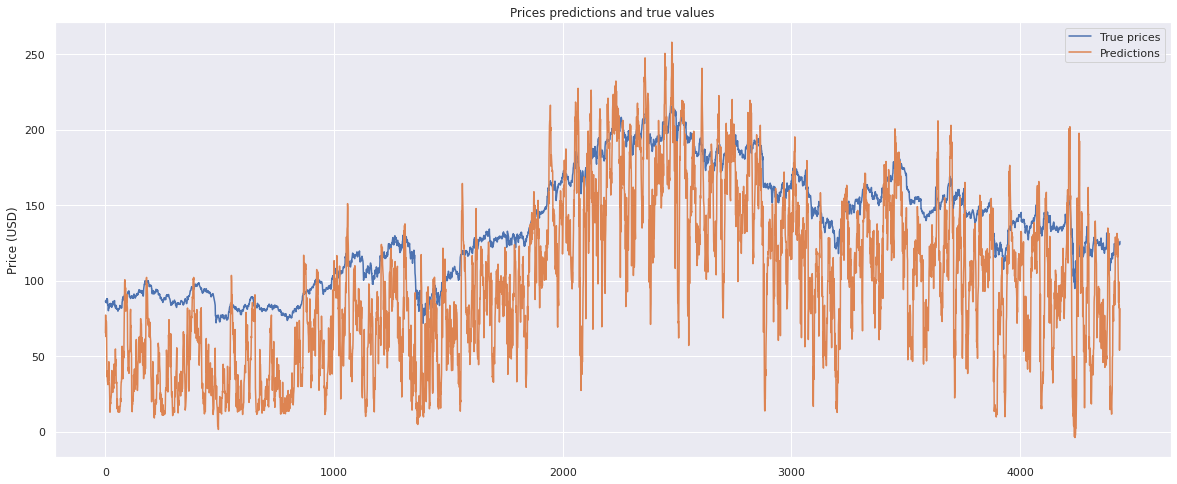

In [12]:
predictions, labels = trainer.predict(test_dataloader)


scaled_preds = data_wrapper.get_unscaled_values(predictions, 'Close')
scaled_labels = data_wrapper.get_unscaled_values(labels, 'Close')

ax = plot_predictions(scaled_labels, scaled_preds)

In [13]:
print(scaled_preds.describe())

count    4438.000000
mean       97.034689
std        53.681507
min        -3.896271
25%        53.918960
50%        95.035768
75%       134.424397
max       257.817749
Name: Close, dtype: float64


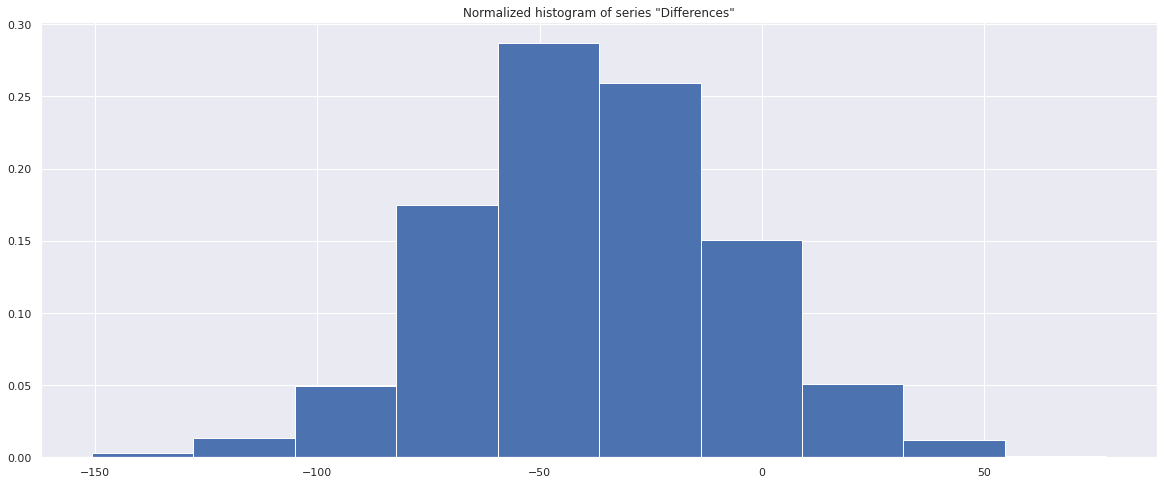

In [14]:
prices_diffs = [(p-y) for p,y in zip(scaled_preds, scaled_labels)]
ax = plot_normalized_histogram(series=pd.Series(prices_diffs, name="Differences"))